# Grab the data from excel

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from scipy import stats
from textwrap import wrap
import seaborn as sns
%matplotlib inline

In [2]:
#initial cleaning function
def clean_sheet(dataframe):
    adj=dataframe.dropna(axis=1,how='all')
    adj=dataframe.set_index(adj.columns[0]) #use stock tickers as the index
    return adj

In [84]:
#pull the data from excel, form a dictionary of tab names and dataframes
tabs_to_grab=['Quarter','Date','Revision','Market cap','Volume','PE','Property']

data_dict={}

for s in tabs_to_grab:
    df=clean_sheet(pd.read_excel(r'C:\Users\Eric.Li\Documents\Post result data\Europe 2007-2018.xlsx',sheet_name=s))
    data_dict[s]=df

In [85]:
# select the right universe
universe_evaluate=(data_dict["Market cap"]>500)&(data_dict["Volume"]>5)
data_dict["Revision"]=data_dict["Revision"][universe_evaluate]
data_dict["Market cap"]=data_dict["Market cap"][data_dict["Market cap"]>500]

In [87]:
# get the price dataframe for certain years; form the price and return datetime from the data from all the years 
def return_from_excel(path, start_year,end_year):
    
    year_range=range(start_year,end_year+1)

    price_list=[]
    rel_price_list=[]
    abs_return_list=[]
    rel_return_list=[]
    for year in year_range:
        price_year=clean_sheet(pd.read_excel(path,sheet_name=str(year))).dropna(how='all',axis=0)
        rel_price=price_year/price_year.loc["SXXP Index"]
        rel_price=rel_price.dropna(how='all',axis=0)
        abs_return=price_year.diff(1,axis=1)/price_year.shift(1,axis=1)
        abs_return=abs_return.dropna(how='all',axis=0)
        rel_return=abs_return - abs_return.loc["SXXP Index"]
        rel_return=rel_return.dropna(how='all',axis=0)
        price_list.append(price_year)
        rel_price_list.append(rel_price)
        abs_return_list.append(abs_return)
        rel_return_list.append(rel_return)

    price=pd.concat(price_list,axis=1).dropna(axis=1,how='all').dropna(axis=0,how='all')
    rel_price=pd.concat(rel_price_list,axis=1).dropna(axis=1,how='all').dropna(axis=0,how='all')
    abs_return=pd.concat(abs_return_list,axis=1).dropna(axis=1,how='all').dropna(axis=0,how='all')
    rel_return=pd.concat(rel_return_list,axis=1).dropna(axis=1,how='all').dropna(axis=0,how='all')

    # transform the datetime to the common timestamp format
    price_column=[i.strftime("%d/%b/%Y") for i in price.columns.tolist() if type(i)!=str]
    rel_price_column=[i.strftime("%d/%b/%Y") for i in rel_price.columns.tolist() if type(i)!=str]
    abs_return_column=[i.strftime("%d/%b/%Y") for i in abs_return.columns.tolist() if type(i)!=str]
    rel_return_column=[i.strftime("%d/%b/%Y") for i in rel_return.columns.tolist() if type(i)!=str]

    price.columns=price_column
    rel_price.columns=rel_price_column
    abs_return.columns=abs_return_column
    rel_return.columns=rel_return_column
    
    return price, rel_price, abs_return,rel_return 


price,rel_price,abs_return,rel_return=return_from_excel(r'C:\Users\Eric.Li\Documents\Post result data\Europe price 2007-2018.xlsx',2007,2018)

In [88]:
# utility function to get volatility from return series
def vol_calc(return_series,vol_lookback,index0):
    hist=len(return_series[:index0])
    if hist<=vol_lookback:
        vol=return_series[:index0].std()
    else:
        vol=return_series[index0-vol_lookback-1:index0].std()
    return vol

In [89]:
# utility function to obtain announcement return (as a multiplier of vol) as a result of day 0 and return dataframe
def EAR_calc(single_date,return_series,EAR_period,vol_lookback):
    if type(single_date)==pd._libs.tslib.Timestamp:
        date_series=return_series.index.tolist()
        if single_date.strftime("%d/%b/%Y") in date_series:
            day0=date_series.index(single_date.strftime("%d/%b/%Y"))
            vol=vol_calc(return_series,vol_lookback,day0)
            if len(return_series.iloc[day0:])<EAR_period:
                ret=return_series[day0:].sum()
                nmove=ret/vol
            else:
                ret=return_series.iloc[day0:day0+EAR_period].sum()
                nmove=ret/vol
            return nmove
        else:
            return None
    else:
        return None

In [90]:
# obtain the announcement return dataframe from price return and date dataframe
def EAR_df(date_df,return_df,EAR_period,vol_lookback):
    EAR_list=[]
    for ticker, date_row in date_df.iterrows():
        if type(ticker)==str: #deal with 
            return_row=return_df.loc[ticker]
            ret_series=date_row.apply(lambda x: EAR_calc(x,return_row,EAR_period,vol_lookback))
            EAR_list.append(ret_series)
        else:
            pass
    EAR_df=pd.concat(EAR_list,axis=1).T
    return EAR_df

# Signal build up

In [91]:
#signal formation (number 1) and use the date as the base dataframe
def signal1_formation(date_df,return_df,EAR_period,EAR_low,EAR_high,revision_df,revision_low,revision_high):
    EAR_return=EAR_df(date_df,return_df,EAR_period,30).fillna(0.0).reindex(revision_df.index.tolist())
    signal1_evaluate=(EAR_return>EAR_low)&(EAR_return<EAR_high) & (revision_df>revision_low)& (revision_df<revision_high)
    signal1=date_df[signal1_evaluate]
    signal1_next=date_df.shift(1,axis=1)[signal1_evaluate]
    return signal1,signal1_next

In [92]:
#Stack signals into a list of tuples (stocks, dates,next earnign dates, next signal dates), convert dates into a common format of datetime
def signal1_stacking(signal1,signal1_next):
    signal1_list=[]
    for ticker, row in signal1.iterrows():
        adj_row=row.dropna()
        if len(adj_row)!=0:
            for idx in range(len(row)):
                date=row.iloc[idx]
                date_next=signal1_next.loc[ticker].iloc[idx]
                if type(date)==pd._libs.tslib.Timestamp:
                    adj_date=date.strftime("%d/%b/%Y") #transform the datetime into a common format
                    loc_date=adj_row.tolist().index(date)
                    if (loc_date>0)&(len(adj_row)>0):
                        next_signal=adj_row.iloc[loc_date-1].strftime("%d/%b/%Y") 
                        adj_next_date=date_next.strftime("%d/%b/%Y") 
                    elif type(date_next)==pd._libs.tslib.Timestamp:
                        next_signal=None
                        adj_next_date=date_next.strftime("%d/%b/%Y") 
                    else:
                        next_signal=None
                        adj_next_date=None                
                    signal1_list.append((row.name,adj_date,adj_next_date,next_signal))
                else:
                    pass
        else:
            pass
    return signal1_list

# Signal result by day

In [93]:
# create a dictionary to have signal information (tuple) as keys and return data time series as values to make it easier to check
#; replace datetime with number of days post announcement to make it more comparable 
def signal1_dict_day(signal1_list,return_df,holding,earning,entry):#if we hold them through next earning
    signal1_dict={}
    for s in signal1_list:
        return_series=return_df.loc[s[0]]       
        if (s[1] in return_series.index):
            if not np.isnan(return_series.loc[s[1]]): 
                day0=return_series.index.tolist().index(s[1]) #index of day 0
                if earning is True:
                    period=holding
                elif type(s[2])==pd._libs.tslib.NaTType:
                    period=holding
                else:
                    period=min(holding,np.busday_count(datetime.strptime(s[1],"%d/%b/%Y"),datetime.strptime(s[2],"%d/%b/%Y"))-entry)
                target_series=return_series.iloc[day0+entry:day0+min(period+entry, len(return_series[day0:]))].dropna()
                target_series.index=range(entry,len(target_series)+entry) #replace datetime with number of days post announcement
                target_series.name=(s[0],s[1])
                signal1_dict[s]=target_series
            else:
                pass
        else:
            pass          
    return signal1_dict

In [94]:
# obtain the dataframe of return time series for the signal stocks, take the signal_return_dict function
def signal1_df_day(signal1,signal1_next,return_df,holding,earning,entry):
    return_series_list=[]
    return_dict=signal1_dict_day(signal1_stacking(signal1,signal1_next),return_df,holding,earning,entry)
    for index,key in return_dict.items():
        return_series_list.append(key)
    try:
        signal1_df=pd.concat(return_series_list,axis=1)
        if earning is True:
            signal1_df=signal1_df.dropna(how='any',axis=1) #drop stocks with limited history to make it more comparable
        else:
            signal1_df=signal1_df.dropna(how='all',axis=1).dropna(how='all',axis=0)
        return signal1_df
    except ValueError:
        return None

In [95]:
# obtain the signal initial result
signal1,signal1_next=signal1_formation(data_dict['Date'],rel_return,2,2,100,data_dict['Revision'],0.02,1)

In [96]:
# obtain the resulting signal dataframe with return series
signal1_abs_df=signal1_df_day(signal1,signal1_next,abs_return,130,True,3)
signal1_rel_df=signal1_df_day(signal1,signal1_next,rel_return,130,True,3)

# List of signals and cumulative returns
signal1_list_abs=((1+signal1_abs_df).cumprod(axis=0)-1).iloc[-1]
signal1_list_abs

signal1_list_rel=((1+signal1_rel_df).cumprod(axis=0)-1).iloc[-1]
signal1_list_rel.sort_values()

ALT GR     26/Apr/2007   -0.698561
SWEDA SS   17/Jul/2008   -0.638188
BAMI IM    10/Nov/2015   -0.608923
REC NO     18/Jul/2014   -0.598856
RHA FP     30/Jul/2008   -0.577578
YIT FH     25/Apr/2008   -0.576385
OTE1V FH   23/Apr/2008   -0.575333
BKT SM     19/Jan/2012   -0.562212
TOM2 NA    24/Oct/2007   -0.557513
MT NA      14/May/2008   -0.554367
YAR NO     18/Apr/2008   -0.535965
BOL SS     08/May/2008   -0.533317
NRE1V FH   07/May/2008   -0.510416
BOL SS     19/Jul/2007   -0.503049
AGFB BB    03/May/2007   -0.502541
SUB NO     22/Jul/2008   -0.497679
NOKIA FH   20/Oct/2011   -0.479696
NHY NO     22/Apr/2008   -0.476560
ALU FP     10/Feb/2012   -0.474728
SSABA SS   23/Jul/2014   -0.469464
MT NA      30/Jul/2008   -0.463527
MHG NO     09/Feb/2011   -0.460912
AIXA GR    01/Mar/2011   -0.436731
KBC BB     12/May/2011   -0.425233
SDF GR     14/Mar/2013   -0.417900
DBK GR     30/Jul/2015   -0.415974
AF FP      18/Feb/2016   -0.402282
CGG FP     31/Jul/2008   -0.394445
CRA1V FH   22/May/20

## Performance plot by announcement day

In [97]:
# Performance analytics
# 1. trading analytics
def trading_analytics_day(signal_df_day):
    ind_return=((1+signal_df_day).cumprod()-1).ffill().iloc[-1]
    signal1_count=len(ind_return)
    if signal1_count==0:
        return None
    else:
        mean_return=ind_return.mean()
        hit_rate=len(ind_return[ind_return>0])/len(ind_return)*1.0
        payoff_ratio=ind_return[ind_return>0].mean()/ind_return[ind_return<0].mean()*-1.0
        return mean_return,signal1_count, hit_rate,payoff_ratio

In [98]:
# 2. aggregate abs/rel performance over time
def perf_chart_day(signal_df_day,xlabel,ylabel,title,figsize,quantile_list):
    quantile_columns=[str(int(i*100))+' percentile' for i in quantile_list]
    cum_return=((1+signal_df_day).cumprod()-1).ffill().mean(axis=1)
    perf_df=((1+signal_df_day).cumprod()-1).ffill().apply(lambda row: row.quantile(quantile_list),axis=1)
    perf_df.columns=quantile_columns
    perf_df["Mean"]=cum_return
    
    ax=perf_df.plot(figsize=figsize)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    vals=ax.get_yticks()
    start=vals[0]
    end=vals[-1]
    ax.set_yticks(np.arange(start,end,0.05))  
    adj_vals=ax.get_yticks()
    ax.set_yticklabels(["{:.0%}".format(x) for x in adj_vals])
    
    mean_return,count,hit, payoff=trading_analytics_day(signal_df_day)
    
    plt.title('mean_return='+str("{:.1%}".format(mean_return)+
              ',count='+str(count)+
              ',hit rate='+str("{:.0%}".format(hit))+
              ',payoff='+str(round(payoff,2))),fontsize=10)
    
    plt.suptitle(title,fontsize=14)
    plt.legend(fontsize=8)
    plt.grid(linestyle='dashed')
    plt.axhline(y=0,color='k')

    plt.show()


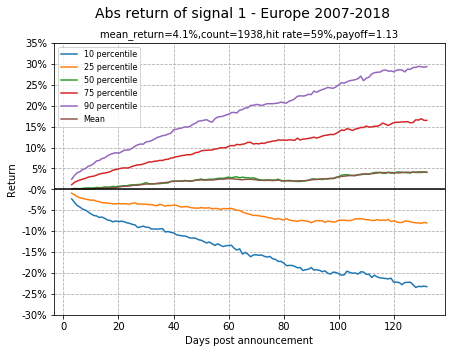

In [101]:
perf_chart_day(signal1_abs_df,"Days post announcement",
           "Return","Abs return of signal 1 - Europe 2007-2018",[7,5],
          [0.1,0.25,0.5,0.75,0.9])

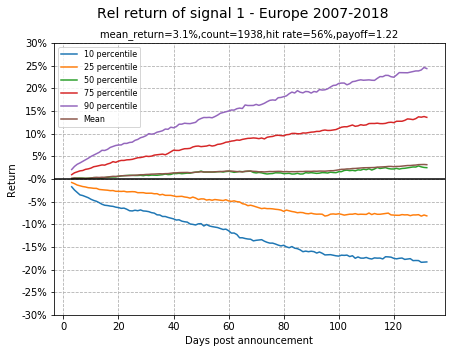

In [100]:
perf_chart_day(signal1_rel_df,"Days post announcement",
           "Return","Rel return of signal 1 - Europe 2007-2018",[7,5],
          [0.1,0.25,0.5,0.75,0.9])

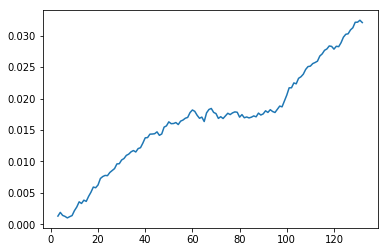

In [103]:
signal1_rel_df.mean(axis=1).cumsum().plot()

C:\Users\Eric.Li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  if __name__ == '__main__':
C:\Users\Eric.Li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  


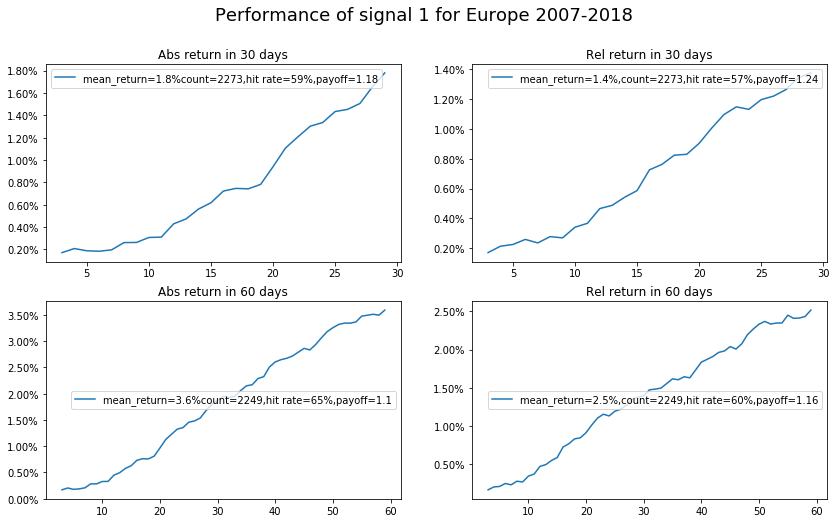

In [53]:
# plot the performance for different holding period 
def plot_by_holding(period_list,figsize,fontsize,title,signal1,signal1_next,abs_return,rel_return,earning,entry):    
    fig=plt.figure(figsize=figsize)
    fig.suptitle(title, fontsize=fontsize)
    for idx, val in enumerate(period_list):
        ax1=fig.add_subplot(len(period_list),2,idx*2+1)
        abs_return_df=signal1_df_day(signal1,signal1_next,abs_return,val,earning,entry)
        abs_cum_return=(1+abs_return_df.mean(axis=1)).cumprod()-1
        ax1.plot(abs_cum_return)

        val1=ax1.get_yticks()
        ax1.set_yticklabels(["{:.2%}".format(x) for x in val1])
    
        ax1.set_title("Abs return in "+str(val)+" days")
        mean1,count1,hit1,payoff1=trading_analytics_day(abs_return_df)
        ax1.legend(['mean_return='+str("{:.1%}".format(mean1))+
                    'count='+str(count1)+
                    ',hit rate='+str("{:.0%}".format(hit1))+
                    ',payoff='+str(round(payoff1,2))])

        ax2=fig.add_subplot(len(period_list),2,idx*2+2)
        rel_return_df=signal1_df_day(signal1,signal1_next,rel_return,val,earning,entry)
        rel_cum_return=(1+rel_return_df.mean(axis=1)).cumprod()-1
        ax2.plot(rel_cum_return)
        
        val2=ax2.get_yticks()
        ax2.set_yticklabels(["{:.2%}".format(x) for x in val2])
        
        ax2.set_title("Rel return in "+str(val)+" days")
        mean2,count2,hit2,payoff2=trading_analytics_day(rel_return_df)
        ax2.legend(['mean_return='+str("{:.1%}".format(mean2))+
                    ',count='+str(count2)+
                    ',hit rate='+str("{:.0%}".format(hit2))+
                    ',payoff='+str(round(payoff2,2))],loc='best')
    plt.show()

    
plot_by_holding([30,60],(14,8),18,"Performance of signal 1 for Europe 2007-2018",signal1,signal1_next,abs_return,rel_return,True,3)

## Plot by years (announcement day)

In [564]:
# plot the performance for different year
def plot_by_year(start_year,end_year,figsize,fontsize,title,signal1_abs_df,signal1_rel_df):    
    year_range=range(start_year,end_year+1)
    fig=plt.figure(figsize=figsize)
    fig.suptitle(title,y=0.9, fontsize=fontsize)
    for idx, val in enumerate(year_range):
        ax1=fig.add_subplot(len(year_range),2,idx*2+1)
        signal1_abs_year=signal1_abs_df.loc[:,signal1_abs_df.apply(lambda x: 
                                                                       (pd.Timestamp(datetime.strptime(x.name[1],"%d/%b/%Y"))>=pd.Timestamp(val,1,1))
                                                                       &(pd.Timestamp(datetime.strptime(x.name[1],"%d/%b/%Y"))<=pd.Timestamp(val,12,31)))]
        signal1_abs_cum=((1+signal1_abs_year).cumprod()-1).ffill().mean(axis=1)
        ax1.plot(signal1_abs_cum)
        ax1.set_title("Abs return in "+str(val))
        try:
            mean_return,count,hit,payoff=trading_analytics_day(signal1_abs_year)
            ax1.legend(['mean_return='+str("{:.1%}".format(mean_return))+
                        ',count='+str(count)+
                        ',hit rate='+str("{:.0%}".format(hit))+
                        ',payoff='+str(round(payoff,2))])
        except:
            pass

        ax2=fig.add_subplot(len(year_range),2,idx*2+2)
        signal1_rel_year=signal1_rel_df.loc[:,signal1_rel_df.apply(lambda x: 
                                                                       (pd.Timestamp(datetime.strptime(x.name[1],"%d/%b/%Y"))>=pd.Timestamp(val,1,1))
                                                                       &(pd.Timestamp(datetime.strptime(x.name[1],"%d/%b/%Y"))<=pd.Timestamp(val,12,31)))]
        signal1_rel_cum=((1+signal1_rel_year).cumprod()-1).ffill().mean(axis=1)
        ax2.plot(signal1_rel_cum)
        ax2.set_title("Rel return in "+str(val))
        try:
            mean_return,count,hit,payoff=trading_analytics_day(signal1_rel_year)
            ax2.legend(['mean_return='+str("{:.1%}".format(mean_return))+
                        ',count='+str(count)+
                        ',hit rate='+str("{:.0%}".format(hit))+
                        ',payoff='+str(round(payoff,2))])
        except:
            pass

    plt.show()


In [ ]:
plot_by_year(2007, 2017,(15,40),20,
             "Performance of signal 1 for Europe 2007-2018",signal1_abs_df,signal1_rel_df)

## Plot by sectors (announcement day)

In [247]:
## sector mapping and unique sector list, add the sector column to the signal
def sector_mapping(ticker,mapping_df):
    mapping=mapping_df.dropna()
    if ticker in mapping.index:
        sector=mapping[ticker]
    else:
        sector=None
    return sector
    
unique_sector=list(set(data_dict["Property"]["Sector"].dropna().values))
signal1_with_sector=signal1.copy()
signal1_next_with_sector=signal1_next.copy()
signal1_with_sector["sector"]=[sector_mapping(i,data_dict["Property"]["Sector"]) for i in signal1_with_sector.index]
signal1_next_with_sector["sector"]=[sector_mapping(i,data_dict["Property"]["Sector"]) for i in signal1_next_with_sector.index]

In [ ]:
# plot the performance for different sectors
def plot_by_sector(sector_list,figsize,fontsize,title,signal1,signal1_next,abs_return,rel_return,holding_period,earning,entry):    
    fig=plt.figure(figsize=figsize)
    fig.suptitle(title, fontsize=fontsize)
    for idx, sector in enumerate(sector_list):
        signal1_sector=signal1[signal1["sector"]==sector].iloc[:,:-1]
        signal1_next_sector=signal1_next[signal1_next["sector"]==sector].iloc[:,:-1]
        
        ax1=fig.add_subplot(len(sector_list),2,idx*2+1)
        abs_return_df=signal1_df_day(signal1_sector,signal1_next_sector,abs_return,holding_period,earning,entry)
        abs_cum_return=(1+abs_return_df.mean(axis=1)).cumprod()-1
        ax1.plot(abs_cum_return)
        ax1.set_title("Abs return in "+str(sector))
        count,hit, payoff=trading_analytics_day(abs_return_df)
        ax1.legend(['count='+str(count)+
                    ',hit rate='+str("{:.0%}".format(hit))+
                    ',payoff='+str(round(payoff,2))])

        ax2=fig.add_subplot(len(sector_list),2,idx*2+2)
        rel_return_df=signal1_df_day(signal1_sector,signal1_next_sector,rel_return,holding_period,earning,entry)
        rel_cum_return=(1+rel_return_df.mean(axis=1)).cumprod()-1
        ax2.plot(rel_cum_return)
        ax2.set_title("Rel return in "+str(sector))
        count,hit, payoff=trading_analytics_day(rel_return_df)
        ax2.legend(['count='+str(count)+
                    ',hit rate='+str("{:.0%}".format(hit))+
                    ',payoff='+str(round(payoff,2))])
    
    plt.show()

In [ ]:
plot_by_sector(unique_sector,(15,60),18,
             "Performance of signal 1 for Europe 2007-2018",signal1_with_sector,signal1_next_with_sector,abs_return,rel_return, 120,True,3)

## Plot by countries (announcement day)

In [1095]:
## unique country list, add the country column to the signal
signal1_with_country=signal1.copy()
signal1_with_country["country"]=[i[-2:] for i in signal1_with_country.index]
signal1_next_with_country=signal1_next.copy()
signal1_next_with_country["country"]=[i[-2:] for i in signal1_next_with_country.index]

unique_country=list(set(signal1_with_country["country"]))

In [565]:
# plot the performance by countries
def plot_by_country(country_list,figsize,fontsize,title,signal1,signal1_next,abs_return,rel_return,holding_period,earning,entry):    
    fig=plt.figure(figsize=figsize)
    fig.suptitle(title, fontsize=fontsize)
    for idx, country in enumerate(country_list):
        signal1_country=signal1[signal1["country"]==country].iloc[:,:-1]
        signal1_next_country=signal1_next[signal1_next["country"]==country].iloc[:,:-1]
        
        ax1=fig.add_subplot(len(country_list),2,idx*2+1)
        #print(signal1_country,signal1_next_country)
        abs_return_df=signal1_df_day(signal1_country,signal1_next_country,abs_return,holding_period,earning,entry)
        if abs_return_df is not None:
            abs_cum_return=(1+abs_return_df.mean(axis=1)).cumprod()-1
            ax1.plot(abs_cum_return)
            ax1.set_title("Abs return in "+str(country))
            count,hit, payoff=trading_analytics_day(abs_return_df)
            ax1.legend(['count='+str(count)+
                        ',hit rate='+str("{:.0%}".format(hit))+
                        ',payoff='+str(round(payoff,2))])
        else:
            pass
        
        ax2=fig.add_subplot(len(country_list),2,idx*2+2)
        rel_return_df=signal1_df_day(signal1_country,signal1_next_country,rel_return,holding_period,earning,entry)
        if rel_return_df is not None:  
            rel_cum_return=(1+rel_return_df.mean(axis=1)).cumprod()-1
            ax2.plot(rel_cum_return)
            ax2.set_title("Rel return in "+str(country))
            count,hit, payoff=trading_analytics_day(rel_return_df)
            ax2.legend(['count='+str(count)+
                        ',hit rate='+str("{:.0%}".format(hit))+
                        ',payoff='+str(round(payoff,2))])
        else:
            pass
    plt.show()

In [ ]:
plot_by_country(unique_country,(15,50),18,
             "Performance of signal 1 for Europe 2007-2018",signal1_with_country,signal1_next_with_country,abs_return,rel_return, 120,True,3)

## Holding through numbers (plot by announcement day)

C:\Users\Eric.Li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  if __name__ == '__main__':
C:\Users\Eric.Li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  


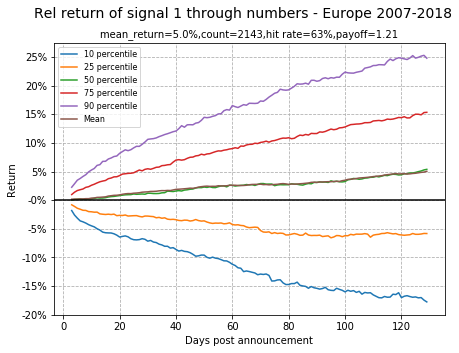

In [22]:
# Hold through numbers
perf_chart_day(signal1_df_day(signal1,signal1_next,rel_return,130,True,3),"Days post announcement",
           "Return","Rel return of signal 1 through numbers - Europe 2007-2018",[7,5],
          [0.1,0.25,0.5,0.75,0.9])

C:\Users\Eric.Li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  if __name__ == '__main__':
C:\Users\Eric.Li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  


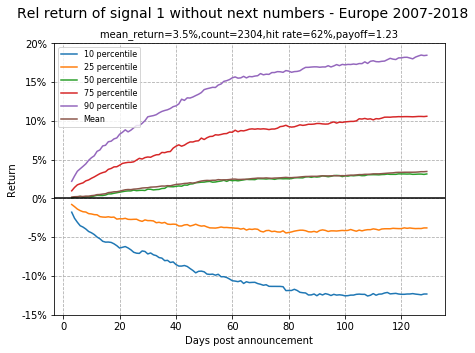

In [24]:
# Not through numbers
perf_chart_day(signal1_df_day(signal1,signal1_next,rel_return,130,False,3),"Days post announcement",
           "Return","Rel return of signal 1 without next numbers - Europe 2007-2018",[7,5],
          [0.1,0.25,0.5,0.75,0.9])

## Plot by size (announcement day)

In [286]:
## grab market cap data
market_cap=data_dict["Market cap"]

## function to grab market cap
def get_market_cap(signal_tuple,market_cap_df,date_df):
    ticker=signal_tuple[0]
    date_series=date_df.loc[ticker]
    cap_series=market_cap_df.loc[ticker]
    timestamp=pd.Timestamp(datetime.strptime(signal_tuple[1],"%d/%b/%Y").year,
                           datetime.strptime(signal_tuple[1],"%d/%b/%Y").month,
                           datetime.strptime(signal_tuple[1],"%d/%b/%Y").day)
    location=date_series.tolist().index(timestamp)
    return cap_series.iloc[location]
    

In [502]:
# add market cap data to signal dataframe and separate 
size_row=signal1_rel_df.apply(lambda column: get_market_cap(column.name,market_cap,data_dict["Date"]),axis=0)

signal_abs_size_df=signal1_abs_df.copy()
signal_size_df=signal1_rel_df.copy()
 
small_cap_abs=signal_abs_size_df.loc[:,size_row<3300]
mid_cap_abs=signal_abs_size_df.loc[:,(size_row>3300)&(size_row<9000)]
large_cap_abs=signal_abs_size_df.loc[:,size_row>9000]

small_cap=signal_size_df.loc[:,size_row<3300]
mid_cap=signal_size_df.loc[:,(size_row>3300)&(size_row<9000)]
large_cap=signal_size_df.loc[:,size_row>9000]

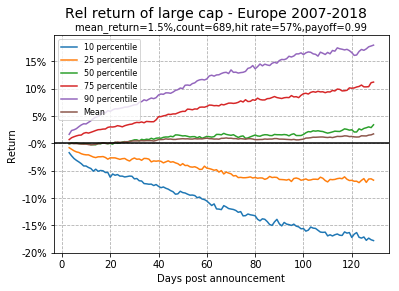

In [503]:
perf_chart_day(large_cap,"Days post announcement",
           "Return","Rel return of large cap - Europe 2007-2018",[6,4],
          [0.1,0.25,0.5,0.75,0.9])

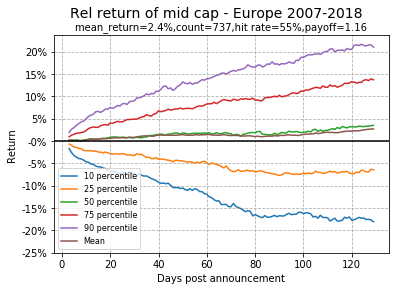

In [504]:
perf_chart_day(mid_cap,"Days post announcement",
           "Return","Rel return of mid cap - Europe 2007-2018",[6,4],
          [0.1,0.25,0.5,0.75,0.9])

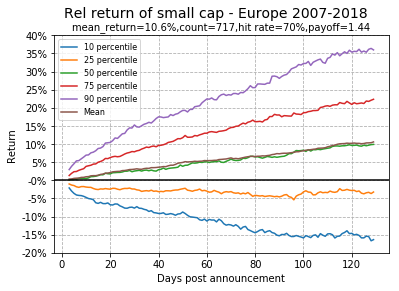

In [35]:
perf_chart_day(small_cap,"Days post announcement",
           "Return","Rel return of small cap - Europe 2007-2018",[6,4],
          [0.1,0.25,0.5,0.75,0.9])

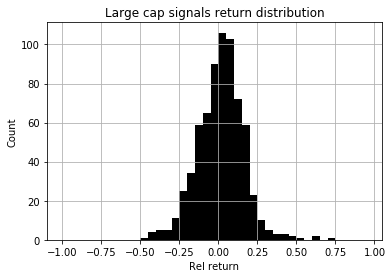

In [505]:
# large cap distribution
plt.figure(figsize=(6,4))
plt.hist(np.array(((1+large_cap).cumprod()-1).iloc[-1]),bins=np.arange(-1,1,0.05),color='k',density=False)
plt.title("Large cap signals return distribution")
plt.xlabel("Rel return")
plt.ylabel("Count")
plt.grid(True)

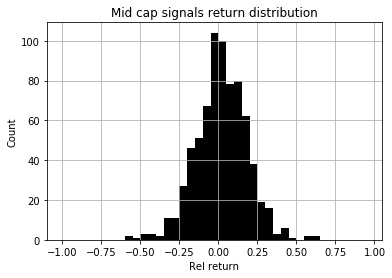

In [506]:
# mid cap distribution
plt.figure(figsize=(6,4))
plt.hist(np.array(((1+mid_cap).cumprod()-1).iloc[-1]),bins=np.arange(-1,1,0.05),color='k',density=False)
plt.title("Mid cap signals return distribution")
plt.xlabel("Rel return")
plt.ylabel("Count")
plt.grid(True)

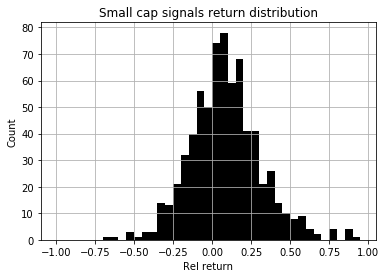

In [507]:
# smal cap distribution
plt.figure(figsize=(6,4))
plt.hist(np.array(((1+small_cap).cumprod()-1).iloc[-1]),bins=np.arange(-1,1,0.05),color='k',density=False)
plt.title("Small cap signals return distribution")
plt.xlabel("Rel return")
plt.ylabel("Count")
plt.grid(True)

## Stop loss (announcement day)

In [39]:
## utility function to get the vol from a column of signal_df
def signal1_vol(signal_column,return_df,vol_lookback):
    signal_tuple=signal_column.name
    signal_series=abs_return.loc[signal_tuple[0]]
    location=signal_series.index.tolist().index(signal_tuple[1])
    vol_range=min(vol_lookback,len(signal_series[:location]))
    signal_vol=signal_series[location-vol_range-1:location].std()
    return signal_vol

In [508]:
# signal_df post stop loss filter 
def signal1_filter_stop(signal_df,stop_level,return_df,vol_lookback):
    vol_row=signal_df.apply(lambda column:signal_vol(column,return_df,vol_lookback),axis=0)
    signal_cum_nmove=((1+signal_df).cumprod()-1).ffill()/vol_row
    signal_df_stop=signal_df[-(signal_cum_nmove.expanding().min().shift(1,axis=0)<-stop_level)]
    return signal_df_stop

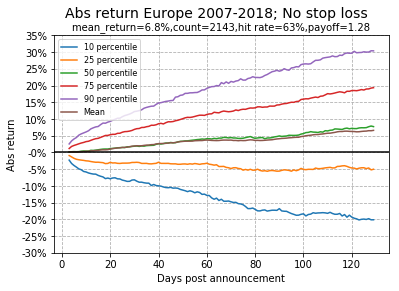

In [509]:
# No stop loss absolute
perf_chart_day(signal1_abs_df,"Days post announcement",
           "Abs return","Abs return Europe 2007-2018"+"; No stop loss",[6,4],
          [0.1,0.25,0.5,0.75,0.9])

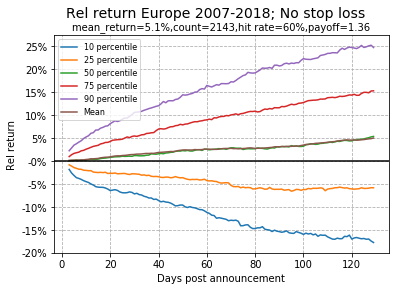

In [510]:
# No stop loss relative
perf_chart(signal1_rel_df,"Days post announcement",
           "Rel return","Rel return Europe 2007-2018"+"; No stop loss",[6,4],
          [0.1,0.25,0.5,0.75,0.9])

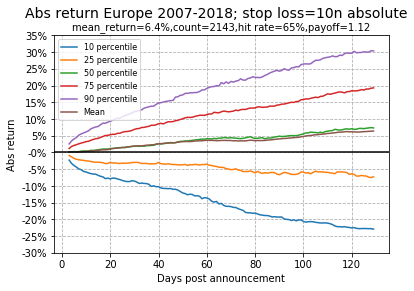

In [56]:
# Absolute stop loss
perf_chart_day(signal1_filter_stop(signal1_abs_df,10,abs_return,30),"Days post announcement",
           "Abs return","Abs return Europe 2007-2018"+"; stop loss="+"10n absolute",[6,4],
          [0.1,0.25,0.5,0.75,0.9])

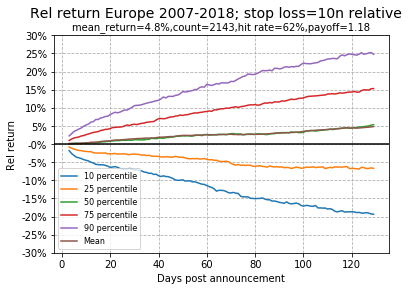

In [57]:
# Rel stop loss
perf_chart_day(signal1_filter_stop(signal1_rel_df,10,rel_return,30),"Days post announcement",
           "Rel return","Rel return Europe 2007-2018"+"; stop loss="+"10n relative",[6,4],
          [0.1,0.25,0.5,0.75,0.9])

## Add absolute/relative high (announcement day)


In [45]:
## filter signal_df with abs/rel high
def signal1_filter_high(signal_df,price_df,rolling_window):
    high_df=price_df.rolling(window=rolling_window,axis=1).max()==price_df
    high_evaluate=signal_df.apply(lambda x: (high_df.loc[x.name[0]].loc[x.name[1]]) or
                                  high_df.loc[x.name[0]].iloc[high_df.loc[x.name[0]].index.tolist().index(x.name[1])+1]) # either day 1 or day 2
    signal_filter_high=signal_df.loc[:,high_evaluate]
    return signal_filter_high

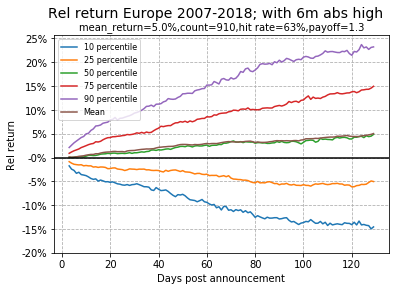

In [61]:
perf_chart_day(signal1_filter_high(signal1_rel_df,price,120),"Days post announcement",
           "Rel return","Rel return Europe 2007-2018"+"; with 6m abs high",[6,4],
          [0.1,0.25,0.5,0.75,0.9])


## Add moving average (announcement day)

In [62]:
## filter signal_df with moving average
def signal1_filter_MA(signal_df,price_df,MA_lookback):
    MA=(price_df.rolling(MA_lookback,axis=1).mean()<price_df)|(price_df.shift(1).rolling(MA_lookback,axis=1).mean()<price_df.shift(1))
    MA_evaluate=signal_df.apply(lambda x: MA.loc[x.name[0]].loc[x.name[1]])
    signal_filter_MA=signal_df.loc[:,MA_evaluate]
    return signal_filter_MA

In [63]:
signal1_MA50_abs_df=signal1_filter_MA(signal1_abs_df,price,50)
signal1_MA50_rel_df=signal1_filter_MA(signal1_rel_df,price,50)

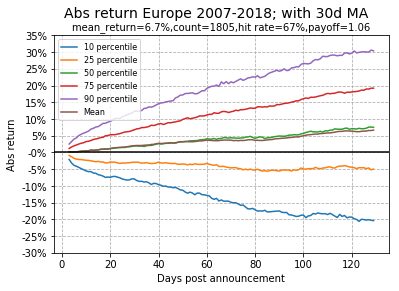

In [64]:
perf_chart_day(signal_filter_MA(signal1_abs_df,price,30),"Days post announcement",
           "Abs return","Abs return Europe 2007-2018"+"; with 30d MA",[6,4],
          [0.1,0.25,0.5,0.75,0.9])

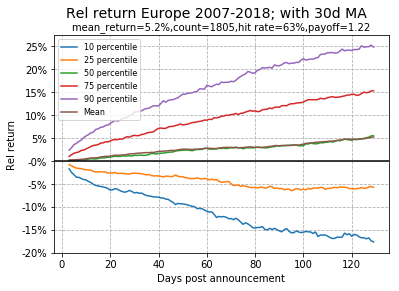

In [50]:
perf_chart_day(signal_filter_MA(signal1_rel_df,price,30),"Days post announcement",
           "Rel return","Rel return Europe 2007-2018"+"; with 30d MA",[6,4],
          [0.1,0.25,0.5,0.75,0.9])


## stop loss, moving average, high price together (announcement day)

In [51]:
signal1_rel_df_stop=signal_filter_stop(signal1_abs_df,-5,abs_return,30)
signal1_rel_df_stop_high=signal_filter_high(signal1_rel_df_stop,price,130)
signal1_rel_df_stop_high_MA=signal_filter_MA(signal1_rel_df_stop_high,price,50)

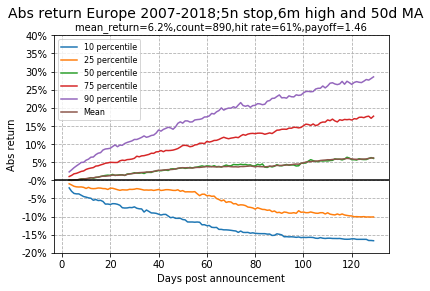

In [52]:
perf_chart_day(signal1_rel_df_stop_high_MA,"Days post announcement",
           "Abs return","Abs return Europe 2007-2018"+";5n stop,6m high and 50d MA",[6,4],
          [0.1,0.25,0.5,0.75,0.9])

# Signal result by actual date - account curve

In [30]:
# create a dictionary to have signal information (tuple) as keys and return data time series as values to make it easier to check
#;use actual dates rather than number of days post announcement
def signal1_dict_date(signal1_list,return_df,holding,earning,signal,entry):#if we hold them through next earning
    signal1_dict={}
    for s in signal1_list:
        return_series=return_df.loc[s[0]]
        if (s[1] in return_series.index):
            if not np.isnan(return_series.loc[s[1]]): 
                day0=return_series.index.tolist().index(s[1]) #index of day 0
                if s[2] is None:
                    period=holding
                elif earning is False:
                    period=min(holding,np.busday_count(datetime.strptime(s[1],"%d/%b/%Y"),datetime.strptime(s[2],"%d/%b/%Y"))-entry)
                elif (signal is False) & (s[3] is not None):
                    period=min(holding,np.busday_count(datetime.strptime(s[1],"%d/%b/%Y"),datetime.strptime(s[3],"%d/%b/%Y"))-entry)
                else:
                    period=holding
                target_series=return_series.iloc[day0+entry:day0+min(period+entry, len(return_series[day0:]))].dropna() # different from return_dict with number of dates post announcement
                target_series.name=(s[0])
                signal1_dict[s]=target_series
            else:
                pass
        else:
            pass          
    return signal1_dict

In [31]:
## signal df function adjusted to the actual dates
def signal1_df_date(date_df,return_df,EAR_low,EAR_high,revision_df,revision_low,revision_high,holding,earning,signal,entry):
    signal1,signal1_next=signal1_formation(date_df,return_df,entry,EAR_low,EAR_high,revision_df,revision_low,revision_high)
    signal1_list=signal1_stacking(signal1,signal1_next)
    signal1_dict=signal1_dict_date(signal1_list,return_df,holding,earning,signal,entry)
    return_list=[]
    for i,v in signal1_dict.items():
        return_list.append(v)
    my_df=pd.concat(return_list,axis=1)
    my_df.columns=list(signal1_dict.keys())
    my_df.index=[datetime.strptime(x,"%d/%b/%Y") for x in my_df.index.tolist()]
    signal1_df=my_df.sort_index()
    return signal1_df

In [104]:
# singal1 dataframe by actual date
signal1_rel_df_date=signal1_df_date(data_dict['Date'],rel_return,2,100,data_dict['Revision'],0.02,1000,120,False,False,2)
signal1_abs_df_date=signal1_df_date(data_dict['Date'],abs_return,2,100,data_dict['Revision'],0.02,1000,120,False,False,2)

In [105]:
## grab volume data
volume=data_dict["Volume"]

## function to grab volume
def get_volume(signal_tuple,volume_df,date_df):
    ticker=signal_tuple[0]
    date_series=date_df.loc[ticker]
    volume_series=volume_df.loc[ticker]
    timestamp=pd.Timestamp(datetime.strptime(signal_tuple[1],"%d/%b/%Y").year,
                           datetime.strptime(signal_tuple[1],"%d/%b/%Y").month,
                           datetime.strptime(signal_tuple[1],"%d/%b/%Y").day)
    location=date_series.tolist().index(timestamp)
    return volume_series.iloc[location]

In [106]:
# create dataframe tracking the pnl accumulation, add liquidity constraint
def signal1_account(signal_df_date,average_gross,capital,volume_df,date_df,liquidity_constraint):
    average_number=signal_df_date.count(axis=1).mean()
    avg_size=average_gross/100/average_number
    size_row=signal_df_date.apply(lambda x: min(avg_size,get_volume(x.name,volume_df,date_df)*liquidity_constraint/capital),axis=0)
    count=signal_df_date.copy()
    count[(count>=0)|(count<0)]=1.0
    gross=(count*size_row).sum(axis=1)
    gross=gross[gross!=0]
    account_curve=(((signal_df_date+1).cumprod()-1)*size_row).ffill().sum(axis=1)
    ind_return=((signal_df_date+1).cumprod()-1).ffill().iloc[-1].dropna()
    turnover=np.abs((count*size_row).fillna(0.0).diff(1)).sum().sum()/(count.shape[0]/260)
    return account_curve,avg_size,gross,ind_return,turnover

## Performance plot by actual date

In [107]:
# Performance analytics
# 1. trading analytics
def trading_analytics_date(signal_account):
    ind_return=signal_account[3]
    signal_count=len(ind_return)
    account_curve=signal_account[0]
    
    if signal_count==0:
        return None
    else:
        mean_return=ind_return.mean()
        hit_rate=len(ind_return[ind_return>0])/len(ind_return)*1.0
        payoff_ratio=ind_return[ind_return>0].mean()/ind_return[ind_return<0].mean()*-1.0
        
        account_price=account_curve+1
        ann_vol=np.std(account_price.diff()/account_price.shift(1))*(260**0.5)
        ann_ret=np.mean(account_price.diff()/account_price.shift(1))*260
        ann_sharpe=ann_ret/ann_vol
        
        low_date=(np.maximum.accumulate(account_curve)-account_curve).idxmax()
        high_date=account_curve[:low_date].idxmax()
        max_dd=1-(1+account_curve[low_date])/(1+account_curve[high_date])
        
        return signal_count,hit_rate,payoff_ratio,ann_ret,ann_vol,ann_sharpe,max_dd

In [108]:
# 2. aggregate abs/rel performance over time
def plot_account_curve(signal_account,xlabel,title,figsize):
    account_curve,avg_size,gross,ind_return,turnover=signal_account
    
    fig=plt.figure(figsize=figsize)
    ax1=fig.add_subplot(1,1,1)
    ln1=ax1.plot(account_curve,label='signal',color='b')

    
    val1=ax1.get_yticks()
    start=val1[0]
    end=val1[-1]
    ax1.set_yticks(np.arange(start,end,0.1))  
    adj_val1=ax1.get_yticks()
    ax1.set_yticklabels(["{:.0%}".format(x) for x in adj_val1])
    
    ax2=ax1.twinx()
    ln2=ax2.plot(gross,label='long-gross',color='silver')

    val2=ax2.get_yticks()
    start=val2[0]
    end=val2[-1]
    ax2.set_yticks(np.arange(start,end,0.1))  
    adj_val2=ax2.get_yticks()
    ax2.set_yticklabels(["{:.0%}".format(x) for x in adj_val2])
    
    count,hit,payoff,ret,vol,sharpe,max_dd=trading_analytics_date(signal_account)
    
    plt.title("\n".join(wrap('count='+str(count)+
                             ',avg_size='+str("{:.1%}".format(avg_size))+
                             ',hit_rate='+str("{:.0%}".format(hit))+
                             ',payoff='+str(round(payoff,1))+
                             ',return='+str("{:.1%}".format(ret))+
                             ',vol='+str("{:.1%}".format(vol))+
                             ',sharpe='+str(round(sharpe,1))+
                             ',turnover='+str(round(turnover,1))+'x'+                             
                             ',max_drawdown='+str("{:.1%}".format(max_dd)))),fontsize=10)
 
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel('Return')
    ax2.set_ylabel('Gross')
    plt.suptitle(title,y=1.05,fontsize=16)
    plt.grid(linestyle='dashed')
    plt.legend(ln1+ln2,[l.get_label() for l in ln1+ln2])
    ax1.axhline(y=0,color='k')

    plt.show()


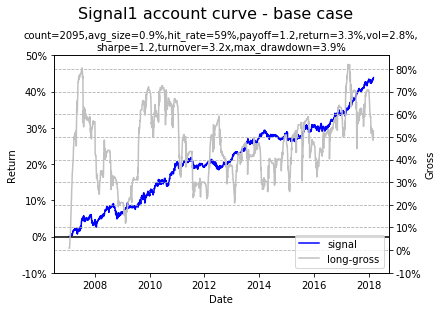

In [109]:
plot_account_curve(signal1_account(signal1_df_date(data_dict['Date'],rel_return,2,100,data_dict['Revision'],0.02,1000,120,False,False,2)
                                   ,50,100,volume,data_dict["Date"],0.1),
                   "Date","Signal1 account curve - base case",[6,4])

## Account curve by sectors

In [69]:
## sector mapping and unique sector list, add the sector column to the signal
def sector_mapping(ticker,mapping_df):
    mapping=mapping_df.dropna()
    if ticker in mapping.index:
        sector=mapping[ticker]
    else:
        sector=None
    return sector

In [70]:
# plot the performance for different sectors
def plot_account_curve_by_sector(sector_df,figsize,fontsize,title,signal_rel_df_date,gross,capital,volume_df,date_df,liquidity_constraint):    
    fig=plt.figure(figsize=figsize)
    fig.suptitle(title, fontsize=fontsize, y=0.89)
    sector_list=list(set(sector_df.dropna().values))
    sector_row=signal_rel_df_date.apply(lambda x: sector_mapping(x.name[0],sector_df),axis=0)
    
    for idx, sector in enumerate(sector_list):
        signal_rel_df_date_sector=signal_rel_df_date.loc[:,sector_row==sector]
                
        ax1=fig.add_subplot(len(sector_list),2,idx+1)
        account=signal1_account(signal_rel_df_date_sector,gross,capital,volume_df,date_df,liquidity_constraint)
        account_curve=account[0]
        ax1.plot(account_curve,color='b')
        ax1.set_title(str(sector))
        count,hit,payoff,ret,vol,sharpe,dd=trading_analytics_date(account)

        ax1.legend(["\n".join(wrap('count='+str(count)+
                                   #',hit_rate='+str("{:.0%}".format(hit))+
                                   #',payoff='+str(round(payoff,2))+
                                   #',avg_size='+str("{:.1%}".format(account[1]))+
                                 ',return='+str("{:.1%}".format(ret))+
                                 ',vol='+str("{:.1%}".format(vol))
                                 #',sharpe='+str(round(sharpe,1))+
                                 #',drawdown='+str("{:.1%}".format(dd))
                                  ))],fontsize=10)        
    


    
    plt.show()

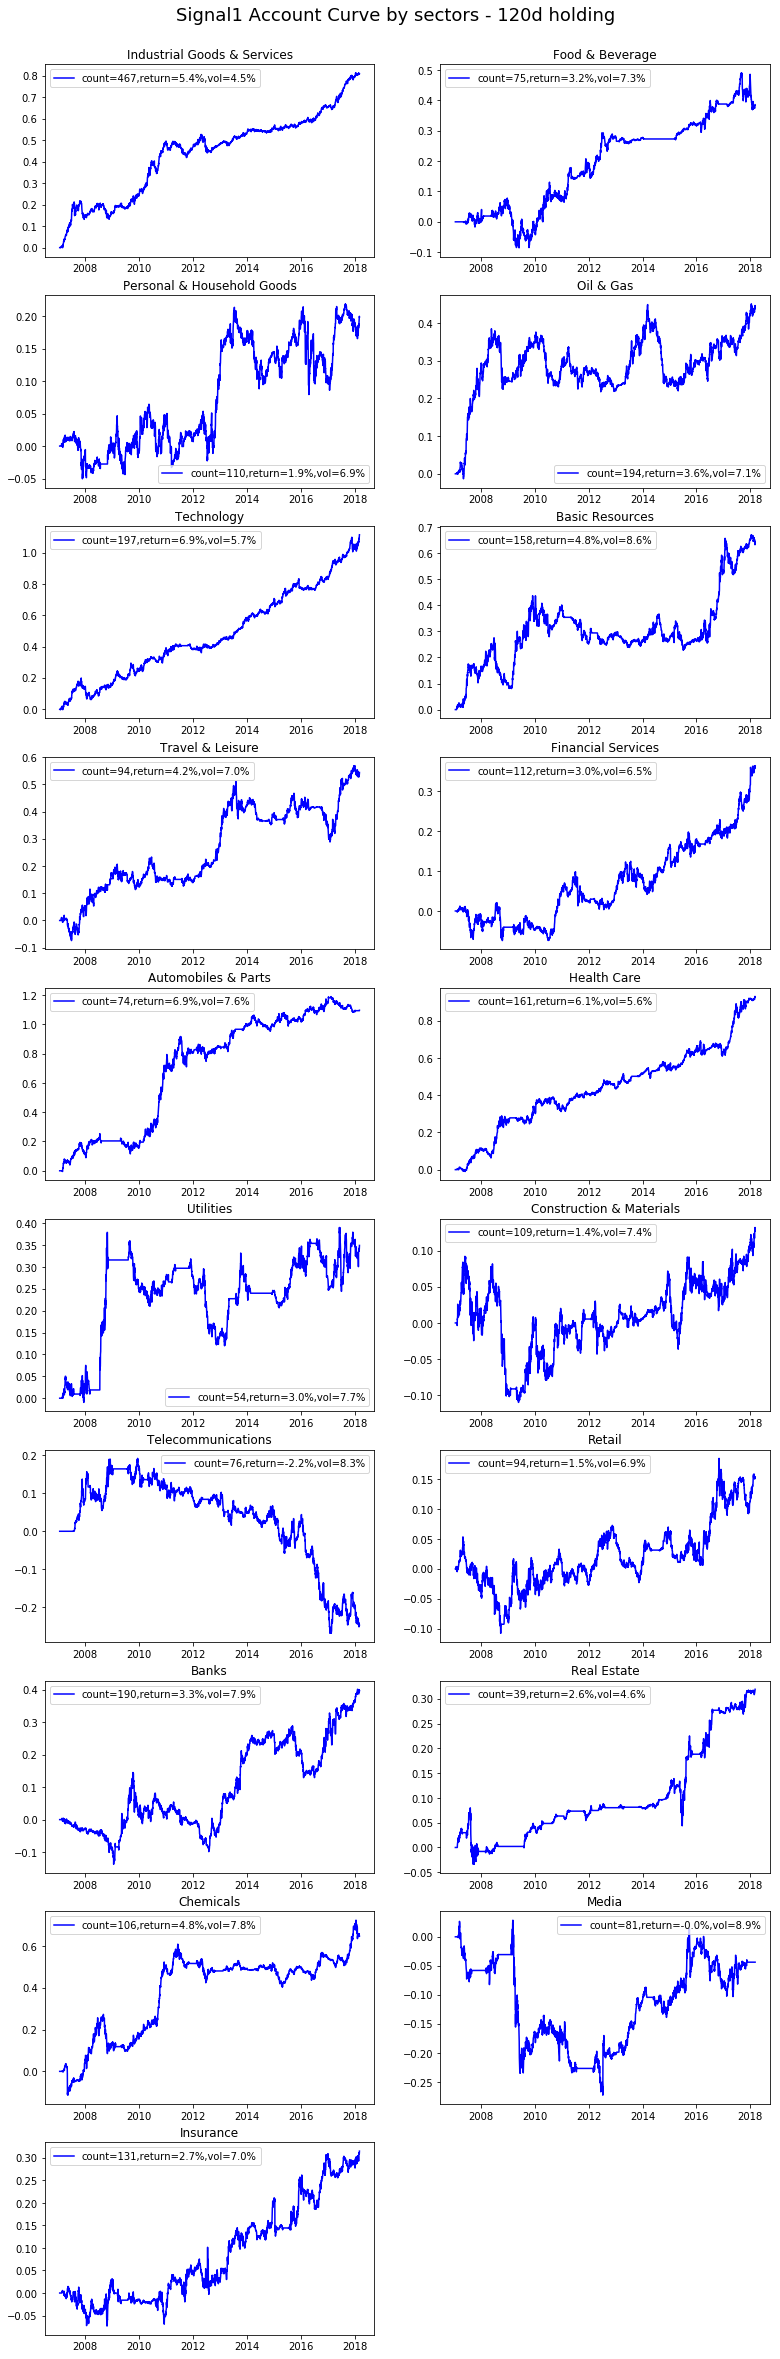

In [71]:
plot_account_curve_by_sector(data_dict["Property"]["Sector"],(13,80),18,
                            "Signal1 Account Curve by sectors - 120d holding",signal1_rel_df_date,
                            50,5,volume,data_dict["Date"],0.1)

## Account curve by countries

In [72]:
# plot the performance for different sectors
def plot_account_curve_by_country(figsize,fontsize,title,signal_rel_df_date,gross,capital,volume_df,date_df,liquidity_constraint):    
    fig=plt.figure(figsize=figsize)
    fig.suptitle(title, fontsize=fontsize, y=0.89)
    country_row=signal_rel_df_date.apply(lambda x: x.name[0][-2:],axis=0)
    country_list=list(set(country_row.dropna().values))      
    
    for idx, country in enumerate(country_list):
        signal_rel_df_date_country=signal_rel_df_date.loc[:,country_row==country]
                
        ax1=fig.add_subplot(len(country_list),2,idx+1)
        account=signal1_account(signal_rel_df_date_country,gross,capital,volume_df,date_df,liquidity_constraint)
        account_curve=account[0]
        ax1.plot(account_curve,color='b')
        ax1.set_title(str(country))
        count,hit,payoff,ret,vol,sharpe,dd=trading_analytics_date(account)

        ax1.legend(["\n".join(wrap('count='+str(count)+
                                   #',hit_rate='+str("{:.0%}".format(hit))+
                                   #',payoff='+str(round(payoff,2))+
                                   #',avg_size='+str("{:.1%}".format(account[1]))+
                                 ',return='+str("{:.1%}".format(ret))+
                                 ',vol='+str("{:.1%}".format(vol))
                                 #',sharpe='+str(round(sharpe,1))+
                                 #',drawdown='+str("{:.1%}".format(dd))
                                  ))],fontsize=10)        
    
    
  
    
    plt.show()

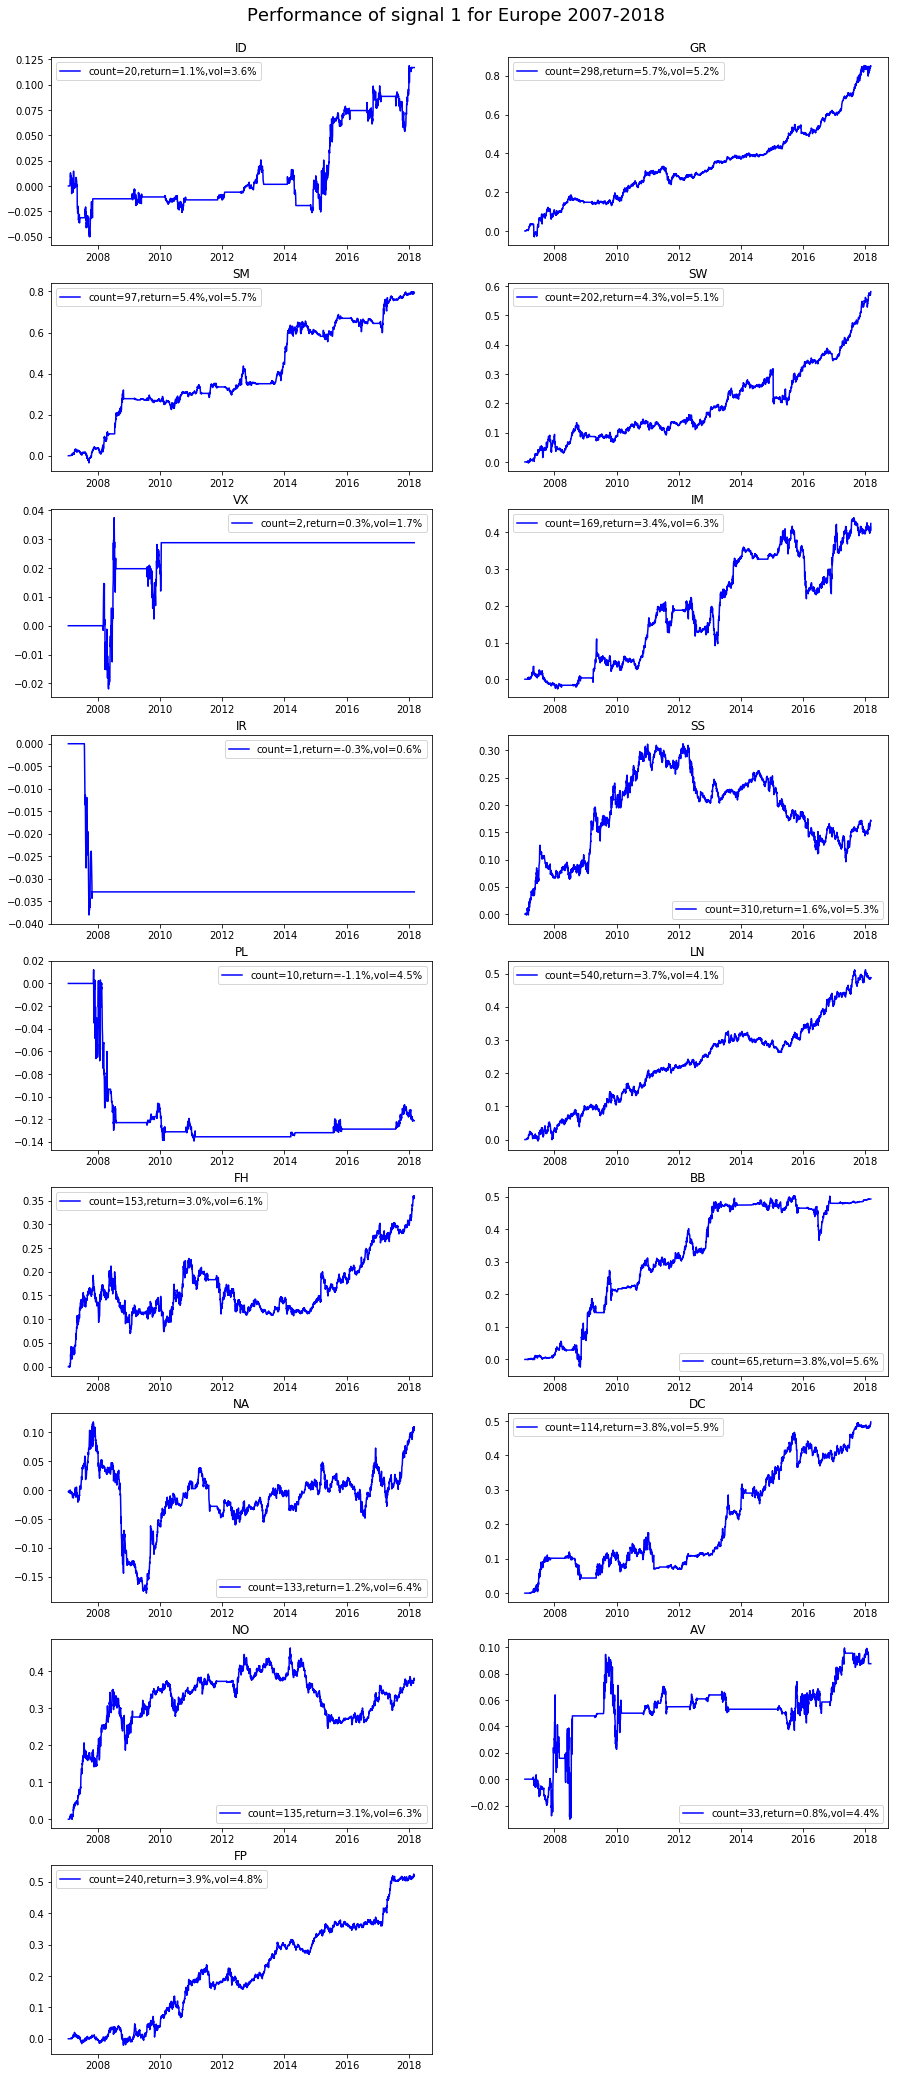

In [73]:
plot_account_curve_by_country((15,70),18,
                            "Performance of signal 1 for Europe 2007-2018",signal1_rel_df_date,
                            50,10,volume,data_dict["Date"],0.1)

## Account curve by size

In [112]:
## grab market cap data
market_cap=data_dict["Market cap"]

## function to grab market cap
def get_market_cap(signal_tuple,market_cap_df,date_df):
    ticker=signal_tuple[0]
    date_series=date_df.loc[ticker]
    cap_series=market_cap_df.loc[ticker]
    timestamp=pd.Timestamp(datetime.strptime(signal_tuple[1],"%d/%b/%Y").year,
                           datetime.strptime(signal_tuple[1],"%d/%b/%Y").month,
                           datetime.strptime(signal_tuple[1],"%d/%b/%Y").day)
    location=date_series.tolist().index(timestamp)
    return cap_series.iloc[location]

In [113]:
# plot the performance for different sizes
def plot_account_curve_by_size(quantile_list,figsize,fontsize,title,signal1_df_date,gross,capital,volume_df,date_df,size_df,liquidity_constraint):    
    fig=plt.figure(figsize=figsize)
    fig.suptitle(title, fontsize=fontsize, y=0.93)
    size_row_date=signal1_df_date.apply(lambda x: get_market_cap(x.name,size_df,date_df),axis=0)
    quantile_value=size_row_date.quantile(quantile_list).values.tolist()
    
    for idx in range(len(quantile_value)-1):
        signal_df_date_size=signal1_df_date.loc[:,(size_row_date>=quantile_value[idx])&(size_row_date<=quantile_value[idx+1])]                             
        
        ax1=fig.add_subplot(len(quantile_list)+1,1,idx+1)      
        account=signal1_account(signal_df_date_size,gross,capital,volume_df,date_df,liquidity_constraint)
        account_curve=account[0]
        ax1.plot(account_curve,color='b')
        ax1.set_title("Account Curve by market cap "+str(round(quantile_value[idx],1))+" - "+str(round(quantile_value[idx+1],1)))
    
        val1=ax1.get_yticks()
        start=val1[0]
        end=val1[-1]
        ax1.set_yticks(np.arange(start,end,0.1))  
        adj_val1=ax1.get_yticks()
        ax1.set_yticklabels(["{:.0%}".format(x) for x in adj_val1])
        
        ax1.grid(linestyle='dashed')
        ax1.axhline(y=0,color='k')
            
        count,hit,payoff,ret,vol,sharpe,dd=trading_analytics_date(account)

        ax1.legend(["\n".join(wrap('count='+str(count)+
                                    ',avg_size='+str("{:.1%}".format(account[1]))+
                                #',hit_rate='+str("{:.0%}".format(hit))+
                                 #',payoff='+str(round(payoff,1))+
                                 ',return='+str("{:.1%}".format(ret))+
                                 ',vol='+str("{:.1%}".format(vol))+
                                 ',sharpe='+str(round(sharpe,1))+
                                 ',turnover='+str(round(account[4],1))+'x'+      
                                 ',drawdown='+str("{:.1%}".format(dd))
                                  ))],fontsize=10)        
    
    
    plt.show()

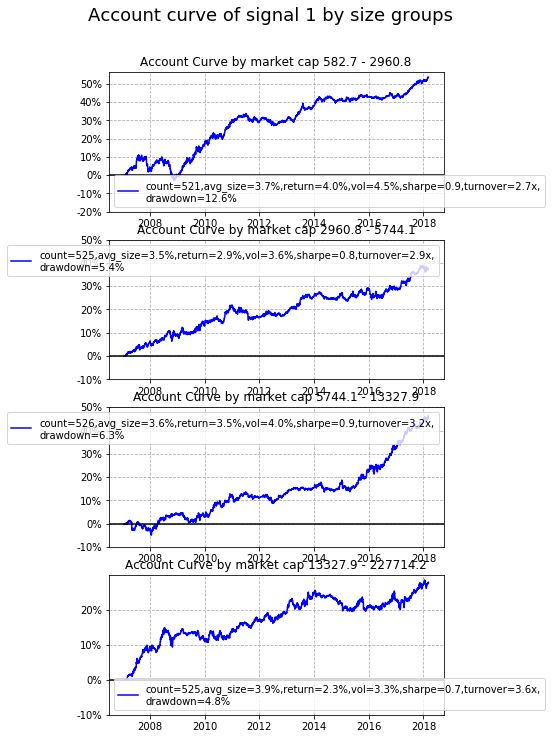

In [115]:
plot_account_curve_by_size([0,0.25,0.5,0.75,1],(6,18),18,
                            "Account curve of signal 1 by size groups",signal1_rel_df_date,
                            50,30,volume,data_dict["Date"],market_cap,0.1)

## Account curve by PE

In [1009]:
## grab market cap data
PE=data_dict["PE"]

## function to grab market cap
def get_PE(signal_tuple, PE_df,date_df):
    ticker=signal_tuple[0]
    date_series=date_df.loc[ticker]
    PE_series=PE_df.loc[ticker]
    timestamp=pd.Timestamp(datetime.strptime(signal_tuple[1],"%d/%b/%Y").year,
                           datetime.strptime(signal_tuple[1],"%d/%b/%Y").month,
                           datetime.strptime(signal_tuple[1],"%d/%b/%Y").day)
    location=date_series.tolist().index(timestamp)
    return PE_series.iloc[location]

In [1050]:
# plot the performance for different PE
def plot_account_curve_by_PE(quantile_list,figsize,fontsize,title,signal1_df_date,gross,capital,volume_df,date_df,size_df,liquidity_constraint):    
    fig=plt.figure(figsize=figsize)
    fig.suptitle(title, fontsize=fontsize, y=0.93)
    PE_row_date=signal1_df_date.apply(lambda x: get_PE(x.name,size_df,date_df),axis=0)
    quantile_value=PE_row_date.quantile(quantile_list).values.tolist()
    
    for idx in range(len(quantile_value)-1):
        signal_df_date_PE=signal1_df_date.loc[:,(PE_row_date>=quantile_value[idx])&(PE_row_date<=quantile_value[idx+1])]            
        
        ax1=fig.add_subplot(len(quantile_list)+1,1,idx+1)      
        account=signal1_account(signal_df_date_PE,gross,capital,volume_df,date_df,liquidity_constraint)
        account_curve=account[0]
        ax1.plot(account_curve,color='b')
        ax1.set_title("Account Curve by PE "+str(round(quantile_value[idx],1))+" - "+str(round(quantile_value[idx+1],1)))
    
        val1=ax1.get_yticks()
        start=val1[0]
        end=val1[-1]
        ax1.set_yticks(np.arange(start,end,0.1))  
        adj_val1=ax1.get_yticks()
        ax1.set_yticklabels(["{:.0%}".format(x) for x in adj_val1])
        
        ax1.grid(linestyle='dashed')
        ax1.axhline(y=0,color='k')
            
        count,hit,payoff,ret,vol,sharpe,dd=trading_analytics_date(account)

        ax1.legend(["\n".join(wrap('count='+str(count)+
                                    ',avg_size='+str("{:.1%}".format(account[1]))+
                                #',hit_rate='+str("{:.0%}".format(hit))+
                                 #',payoff='+str(round(payoff,1))+
                                 ',return='+str("{:.1%}".format(ret))+
                                 ',vol='+str("{:.1%}".format(vol))+
                                 ',sharpe='+str(round(sharpe,1))+
                                 ',turnover='+str(round(account[4],1))+'x'+      
                                 ',drawdown='+str("{:.1%}".format(dd))
                                  ))],fontsize=10)        
    
    
    plt.show()

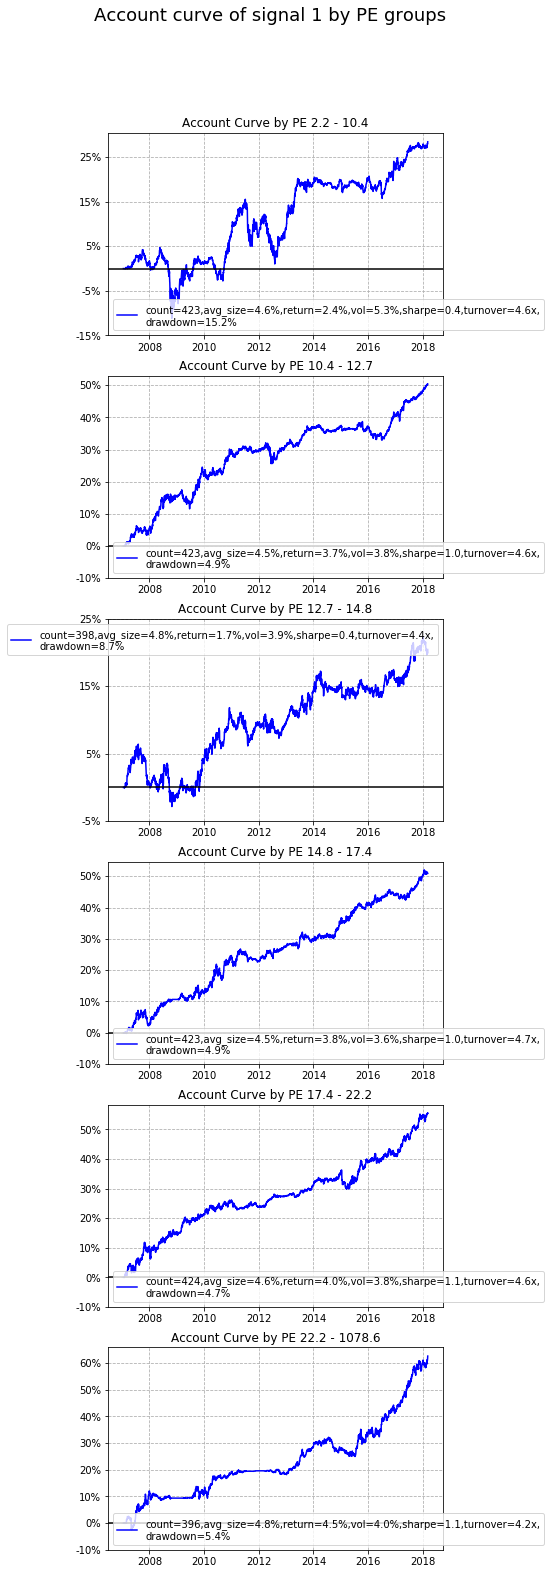

In [1055]:
plot_account_curve_by_PE([0,0.17,0.34,0.5,0.67,0.84,1],(6,35),18,
                            "Account curve of signal 1 by PE groups",signal1_rel_df_date,
                            50,20,volume,data_dict["Date"],PE,0.1)

## Account curve by different holding periods

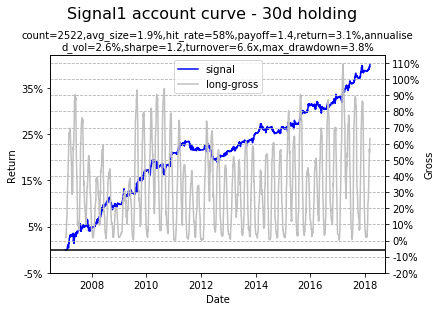

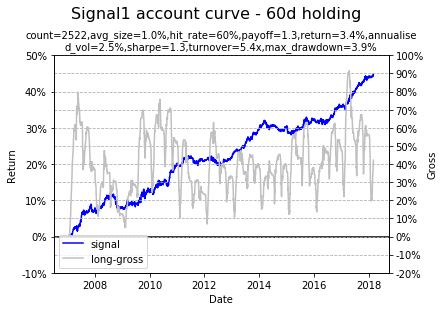

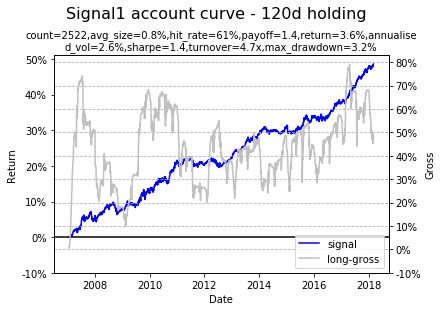

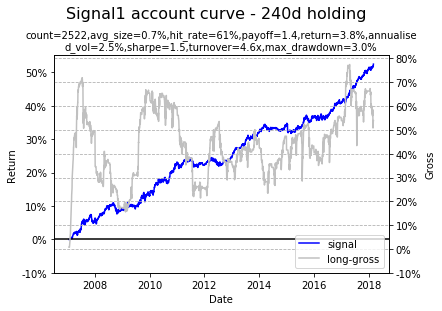

In [836]:
plot_account_curve(signal1_account(signal1_df_date(data_dict['Date'],rel_return,2,100,data_dict['Revision'],0.02,1000,30,False,False,2)
                                   ,50,100,volume,data_dict["Date"],0.1),
                                   "Date","Signal1 account curve - 30d holding",[6,4])

plot_account_curve(signal1_account(signal1_df_date(data_dict['Date'],rel_return,2,100,data_dict['Revision'],0.02,1000,60,False,False,2)
                                   ,50,100,volume,data_dict["Date"],0.1),
                                   "Date","Signal1 account curve - 60d holding",[6,4])

plot_account_curve(signal1_account(signal1_df_date(data_dict['Date'],rel_return,2,100,data_dict['Revision'],0.02,1000,120,False,False,2)
                                   ,50,100,volume,data_dict["Date"],0.1),
                                   "Date","Signal1 account curve - 120d holding",[6,4])

plot_account_curve(signal1_account(signal1_df_date(data_dict['Date'],rel_return,2,100,data_dict['Revision'],0.02,1000,240,False,False,2)
                                   ,50,100,volume,data_dict["Date"],0.1),
                                   "Date","Signal1 account curve - 240d holding",[6,4])

## Account curve with focus on holding through next earning/signal

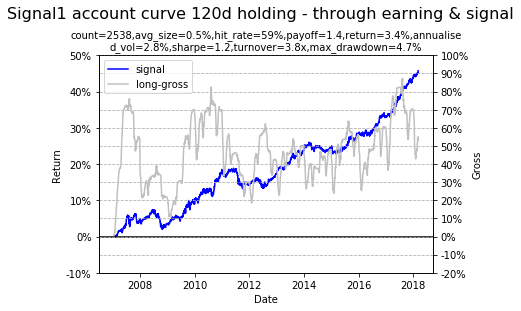

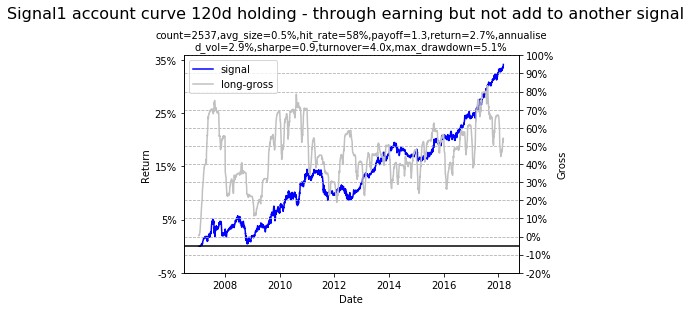

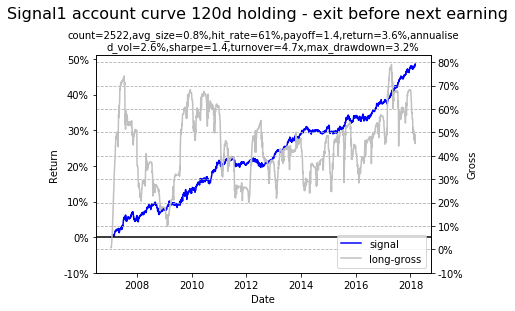

In [833]:
plot_account_curve(signal1_account(signal1_df_date(data_dict['Date'],rel_return,2,100,data_dict['Revision'],0.02,1000,120,True,True,2)
                                   ,50,100,volume,data_dict["Date"],0.1),"Date","Signal1 account curve 120d holding - through earning & signal",[6,4])

plot_account_curve(signal1_account(signal1_df_date(data_dict['Date'],rel_return,2,100,data_dict['Revision'],0.02,1000,120,True,False,2)
                                   ,50,100,volume,data_dict["Date"],0.1),"Date","Signal1 account curve 120d holding - through earning but not add to another signal",[6,4])

plot_account_curve(signal1_account(signal1_df_date(data_dict['Date'],rel_return,2,100,data_dict['Revision'],0.02,1000,120,False,False,2)
                                   ,50,100,volume,data_dict["Date"],0.1),"Date","Signal1 account curve 120d holding - exit before next earning",[6,4])

## Account curve by entry point

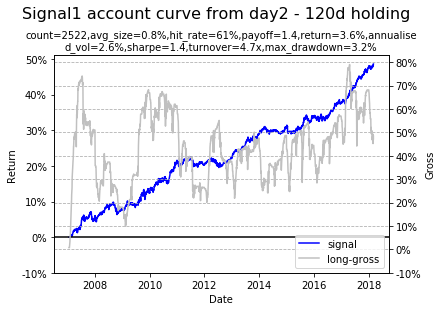

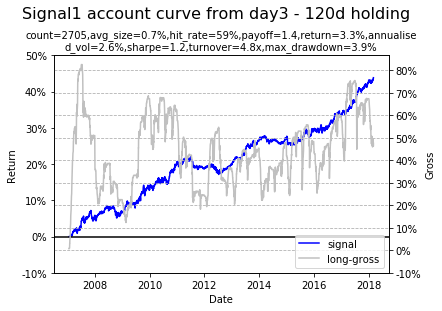

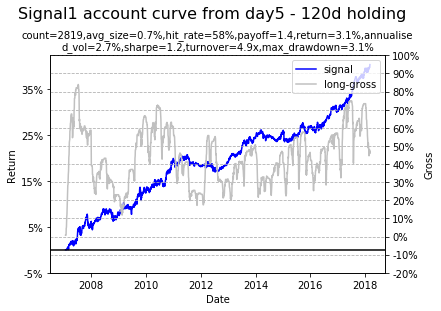

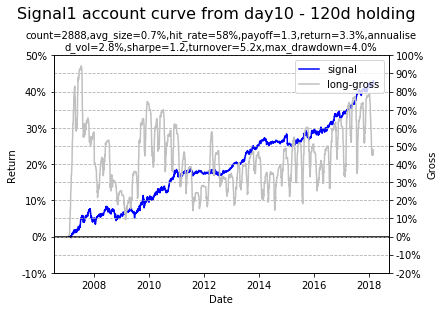

In [840]:
plot_account_curve(signal1_account(signal1_df_date(data_dict['Date'],rel_return,2,100,data_dict['Revision'],0.02,1000,120,False,False,2)
                                   ,50,100,volume,data_dict["Date"],0.1),
                   "Date","Signal1 account curve from day2 - 120d holding",[6,4])

plot_account_curve(signal1_account(signal1_df_date(data_dict['Date'],rel_return,2,100,data_dict['Revision'],0.02,1000,120,False,False,3)
                                   ,50,100,volume,data_dict["Date"],0.1),
                   "Date","Signal1 account curve from day3 - 120d holding",[6,4])

plot_account_curve(signal1_account(signal1_df_date(data_dict['Date'],rel_return,2,100,data_dict['Revision'],0.02,1000,120,False,False,5)
                                   ,50,100,volume,data_dict["Date"],0.1),
                   "Date","Signal1 account curve from day5 - 120d holding",[6,4])

plot_account_curve(signal1_account(signal1_df_date(data_dict['Date'],rel_return,2,100,data_dict['Revision'],0.02,1000,120,False,False,10)
                                   ,50,100,volume,data_dict["Date"],0.1),
                   "Date","Signal1 account curve from day10 - 120d holding",[6,4])

## Account curve with stop loss

In [875]:
## utility function to get the vol from a column of signal_df
def signal1_vol(signal_column,return_df,vol_lookback):
    signal_tuple=signal_column.name
    signal_series=abs_return.loc[signal_tuple[0]]
    location=signal_series.index.tolist().index(signal_tuple[1])
    vol_range=min(vol_lookback,len(signal_series[:location]))
    signal_vol=signal_series[location-vol_range-1:location].std()
    return signal_vol

In [876]:
# signal_df post stop loss filter 
def signal1_filter_stop(signal_df,stop_level,return_df,vol_lookback):
    vol_row=signal_df.apply(lambda column:signal1_vol(column,return_df,vol_lookback),axis=0)
    signal_cum_nmove=((1+signal_df).cumprod()-1).ffill()/vol_row
    signal_df_stop=signal_df[-(signal_cum_nmove.expanding().min().shift(1,axis=0)<-stop_level)]
    return signal_df_stop

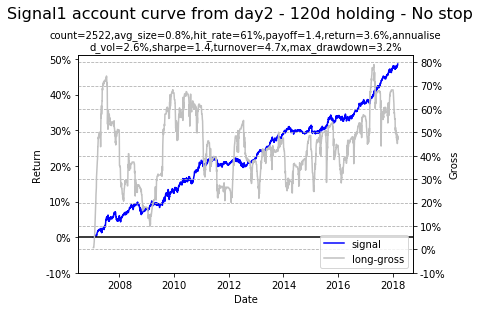

In [877]:
plot_account_curve(signal1_account(signal1_rel_df_date
                                   ,50,100,volume,data_dict["Date"],0.1),
                   "Date","Signal1 account curve from day2 - 120d holding - No stop",[6,4])

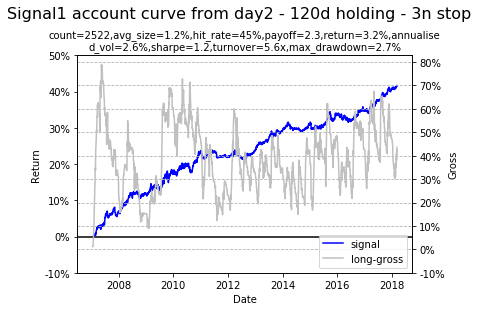

In [878]:
plot_account_curve(signal1_account(signal1_filter_stop(signal1_rel_df_date,3,rel_return,30)
                                   ,50,100,volume,data_dict["Date"],0.1),
                   "Date","Signal1 account curve from day2 - 120d holding - 3n stop",[6,4])

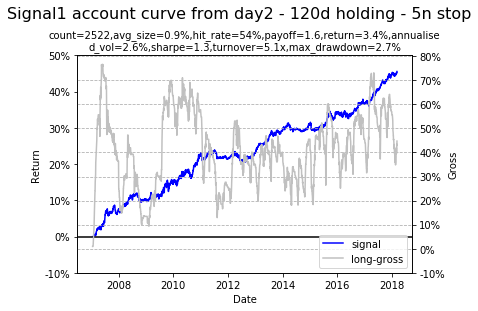

In [879]:
plot_account_curve(signal1_account(signal1_filter_stop(signal1_rel_df_date,5,rel_return,30)
                                   ,50,100,volume,data_dict["Date"],0.1),
                   "Date","Signal1 account curve from day2 - 120d holding - 5n stop",[6,4])

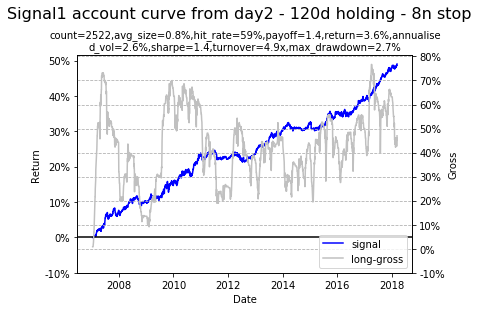

In [880]:
plot_account_curve(signal1_account(signal1_filter_stop(signal1_rel_df_date,8,rel_return,30)
                                   ,50,100,volume,data_dict["Date"],0.1),
                   "Date","Signal1 account curve from day2 - 120d holding - 8n stop",[6,4])

## Account curve with drawdown stop

In [214]:
# signal_df post stop loss filter 
def signal1_filter_dd(signal_df,dd_level,return_df,vol_lookback):
    vol_row=signal_df.apply(lambda column:signal_vol(column,return_df,vol_lookback),axis=0)
    acct=(1+signal_df).cumprod()-1
    signal_dd=(acct.cummax(axis=0)-acct).expanding(min_periods=1).max()/vol_row
    signal_filter_dd=signal_df[-(signal_dd.shift(1,axis=0)>dd_level)]
    return signal_filter_dd

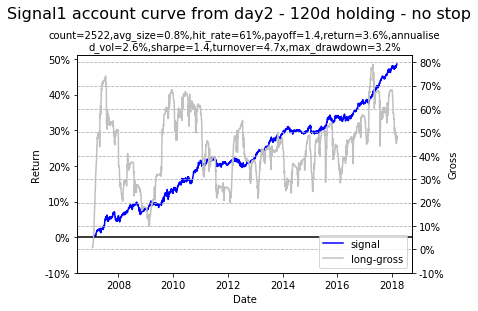

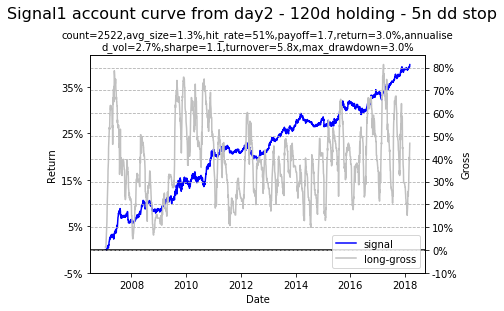

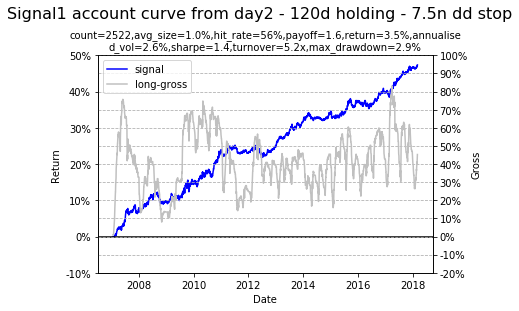

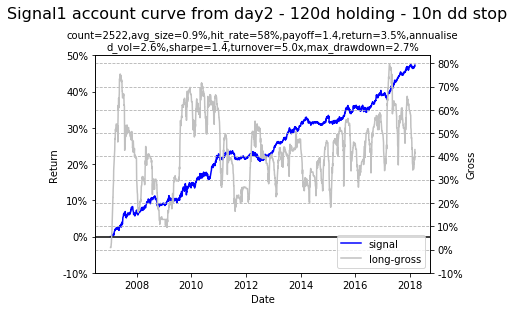

In [881]:
plot_account_curve(signal1_account(signal1_rel_df_date,50,100,volume,data_dict["Date"],0.1),
                   "Date","Signal1 account curve from day2 - 120d holding - no stop",[6,4])

plot_account_curve(signal1_account(signal1_filter_dd(signal1_rel_df_date,5,rel_return,30)
                                   ,50,100,volume,data_dict["Date"],0.1),
                   "Date","Signal1 account curve from day2 - 120d holding - 5n dd stop",[6,4])

plot_account_curve(signal1_account(signal1_filter_dd(signal1_rel_df_date,7.5,rel_return,30)
                                   ,50,100,volume,data_dict["Date"],0.1),
                   "Date","Signal1 account curve from day2 - 120d holding - 7.5n dd stop",[6,4])

plot_account_curve(signal1_account(signal1_filter_dd(signal1_rel_df_date,10,rel_return,30)
                                   ,50,100,volume,data_dict["Date"],0.1),
                   "Date","Signal1 account curve from day2 - 120d holding - 10n dd stop",[6,4])

## Account curve with moving average

In [882]:
## filter signal_df with moving average
def signal1_filter_MA(signal_df,price_df,MA_lookback):
    MA=(price_df.rolling(MA_lookback,axis=1).mean()<price_df)|(price_df.shift(1).rolling(MA_lookback,axis=1).mean()<price_df.shift(1))
    MA_evaluate=signal_df.apply(lambda x: MA.loc[x.name[0]].loc[x.name[1]])
    signal_filter_MA=signal_df.loc[:,MA_evaluate]
    return signal_filter_MA

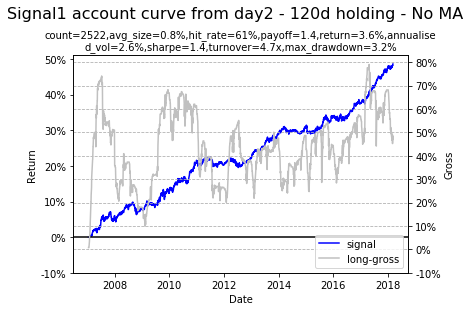

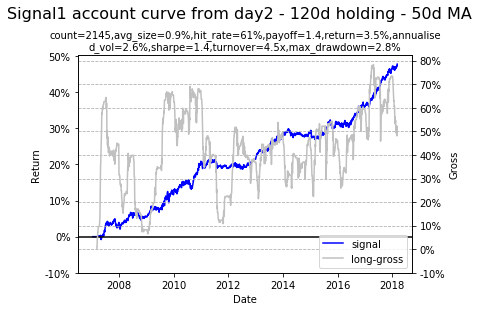

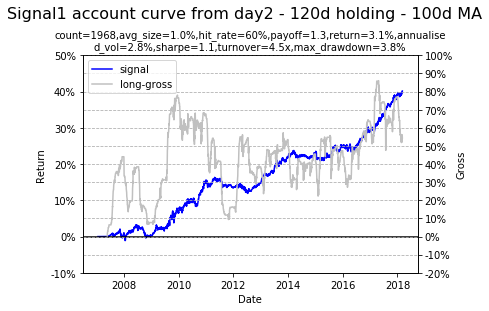

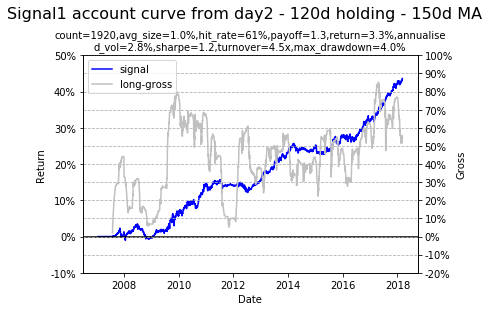

In [883]:
plot_account_curve(signal1_account(signal1_rel_df_date,50,100,volume,data_dict["Date"],0.1),
                   "Date","Signal1 account curve from day2 - 120d holding - No MA",[6,4])

plot_account_curve(signal1_account(signal1_filter_MA(signal1_rel_df_date,price,50)
                                   ,50,100,volume,data_dict["Date"],0.1),
                   "Date","Signal1 account curve from day2 - 120d holding - 50d MA",[6,4])

plot_account_curve(signal1_account(signal1_filter_MA(signal1_rel_df_date,price,100)
                                   ,50,100,volume,data_dict["Date"],0.1),
                   "Date","Signal1 account curve from day2 - 120d holding - 100d MA",[6,4])

plot_account_curve(signal1_account(signal1_filter_MA(signal1_rel_df_date,price,150)
                                   ,50,100,volume,data_dict["Date"],0.1),
                   "Date","Signal1 account curve from day2 - 120d holding - 150d MA",[6,4])

## Account curve with abs/rel high

In [216]:
## filter signal_df with abs/rel high
def signal1_filter_high(signal_df,price_df,rolling_window):
    high_df=price_df.rolling(window=rolling_window,axis=1).max()==price_df
    high_evaluate=signal_df.apply(lambda x: (high_df.loc[x.name[0]].loc[x.name[1]]) or
                                  high_df.loc[x.name[0]].iloc[high_df.loc[x.name[0]].index.tolist().index(x.name[1])+1]) # either day 1 or day 2
    signal_filter_high=signal_df.loc[:,high_evaluate]
    return signal_filter_high

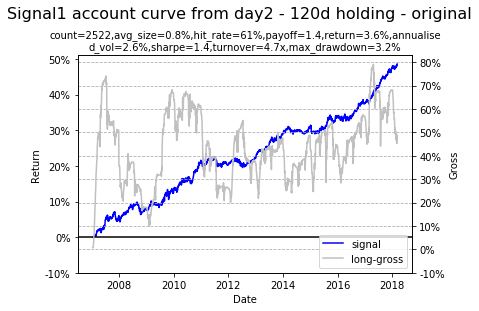

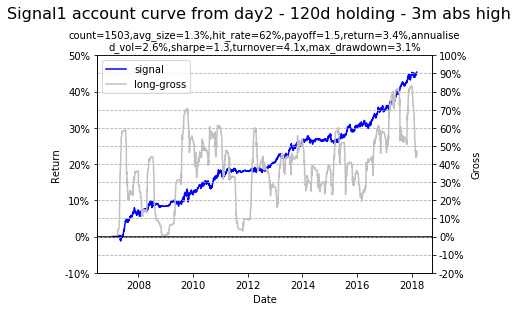

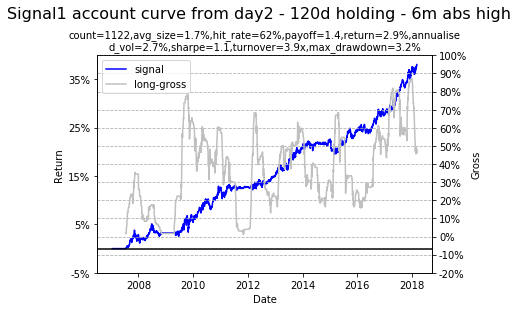

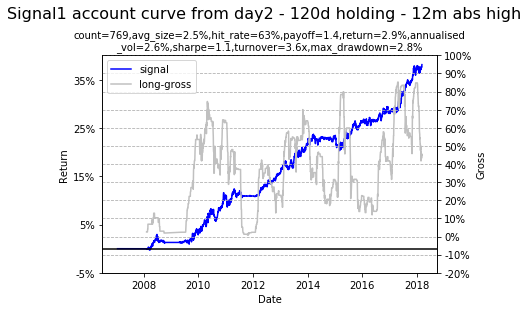

In [884]:
plot_account_curve(signal1_account(signal1_rel_df_date,50,100,volume,data_dict["Date"],0.1),
                   "Date","Signal1 account curve from day2 - 120d holding - original",[6,4])

plot_account_curve(signal1_account(signal1_filter_high(signal1_rel_df_date,price,60)
                                   ,50,100,volume,data_dict["Date"],0.1),
                   "Date","Signal1 account curve from day2 - 120d holding - 3m abs high",[6,4])

plot_account_curve(signal1_account(signal1_filter_high(signal1_rel_df_date,price,120)
                                   ,50,100,volume,data_dict["Date"],0.1),
                   "Date","Signal1 account curve from day2 - 120d holding - 6m abs high",[6,4])

plot_account_curve(signal1_account(signal1_filter_high(signal1_rel_df_date,price,240)
                                   ,50,100,volume,data_dict["Date"],0.1),
                   "Date","Signal1 account curve from day2 - 120d holding - 12m abs high",[6,4])

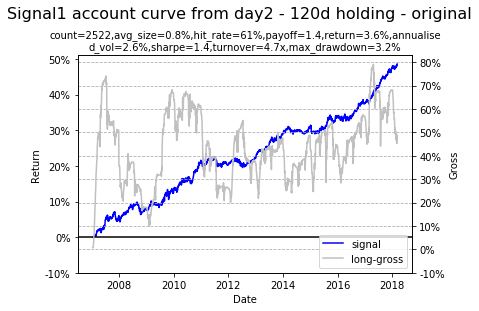

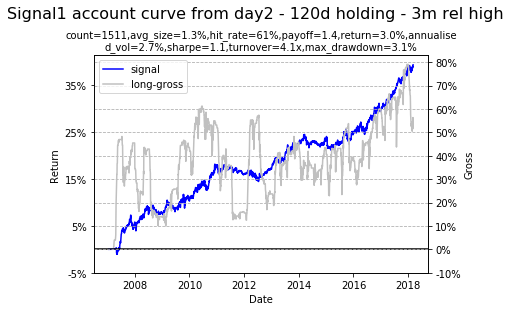

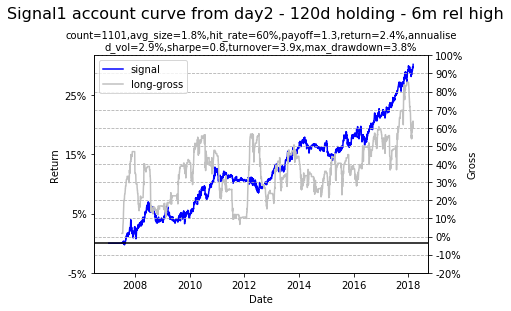

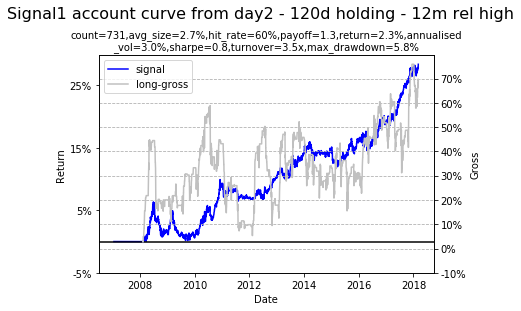

In [885]:
plot_account_curve(signal1_account(signal1_rel_df_date,50,100,volume,data_dict["Date"],0.1),
                   "Date","Signal1 account curve from day2 - 120d holding - original",[6,4])

plot_account_curve(signal1_account(signal1_filter_high(signal1_rel_df_date,rel_price,60)
                                   ,50,100,volume,data_dict["Date"],0.1),
                   "Date","Signal1 account curve from day2 - 120d holding - 3m rel high",[6,4])

plot_account_curve(signal1_account(signal1_filter_high(signal1_rel_df_date,rel_price,120)
                                   ,50,100,volume,data_dict["Date"],0.1),
                   "Date","Signal1 account curve from day2 - 120d holding - 6m rel high",[6,4])

plot_account_curve(signal1_account(signal1_filter_high(signal1_rel_df_date,rel_price,240)
                                   ,50,100,volume,data_dict["Date"],0.1),
                   "Date","Signal1 account curve from day2 - 120d holding - 12m rel high",[6,4])

## Stress test the base case by altering earning upgrade and price move up

In [726]:
# get the revision and EAR quantile
revision_list=data_dict['Revision'].unstack(level=-1).dropna()
revision_quantile=revision_list.quantile([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]).tolist()
EAR_full=EAR_df(data_dict["Date"],rel_return,2,30).fillna(0.0).loc[data_dict['Revision'].index.tolist()]
EAR_list=EAR_full.unstack(level=-1)[EAR_full.unstack(level=-1)!=0]
EAR_quantile=EAR_list.quantile([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]).tolist()

In [730]:
# build the monster dictionary of different scenarios of base signal, this is gonna take an hour!!!!!!!!!!!!!
EAR_upgrade_dict={}

for idx in range(len(EAR_quantile)-1):
    for i in range(len(revision_quantile)-1):
        EAR_upgrade_dict[("Move "+str(round(EAR_quantile[idx],1))+str(" to ")+str(round(EAR_quantile[idx+1],1)),
                          "Upgrade "+str("{:.1%}".format(revision_quantile[i]))+str(" to ")+str("{:.1%}".format(revision_quantile[i+1])))]=trading_analytics_date(signal1_account(
                                    signal1_df_date(data_dict['Date'],rel_return,EAR_quantile[idx],EAR_quantile[idx+1],data_dict['Revision'],revision_quantile[i],revision_quantile[i+1],120,True,True,2)
                                   ,50,100,volume,data_dict["Date"],0.1))

In [735]:
# Build a dummy dataframe with the relevant column and index names
EAR_upgrade_df=pd.DataFrame(np.zeros((10,10)),
                  columns=["Upgrade "+str("{:.1%}".format(revision_quantile[i]))+str(" to ")+str("{:.1%}".format(revision_quantile[i+1])) for i in range(len(revision_quantile)-1)],
                  index=["Move "+str(round(EAR_quantile[i],1))+str(" to ")+str(round(EAR_quantile[i+1],1)) for i in range(len(EAR_quantile)-1)])

In [770]:
# fill in relevant sharpe data
EAR_upgrade_sharpe=EAR_upgrade_df.copy()
for i,ival in enumerate(EAR_upgrade_sharpe.index.tolist()):
    for j,jval in enumerate(EAR_upgrade_sharpe.columns.tolist()):
        EAR_upgrade_sharpe.iloc[i,j]=round(EAR_upgrade_dict[(ival,jval)][5],2)

In [788]:
# fill in relevant return data
EAR_upgrade_ret=EAR_upgrade_df.copy()
for i,ival in enumerate(EAR_upgrade_ret.index.tolist()):
    for j,jval in enumerate(EAR_upgrade_ret.columns.tolist()):
        EAR_upgrade_ret.iloc[i,j]=round(EAR_upgrade_dict[(ival,jval)][3],3)

## Market correlation

In [928]:
# Signal account curve
account_rel=signal1_account(signal1_rel_df_date,50,100,volume,data_dict["Date"],0.1)[0]
account_rel.name="Signal1 rel"
account_abs=signal1_account(signal1_abs_df_date,100,100,volume,data_dict["Date"],0.1)[0]
account_abs.name="Signal1 abs"

In [978]:
# Market
account_SXXP=(1+abs_return.loc["SXXP Index"]).cumprod()-1
account_momentum=(1+abs_return.loc["GSRPEMEL Index"]).cumprod()-1
account_yield=(1+abs_return.loc["USGG10YR Index"]).cumprod()-1
account_SPX=(1+abs_return.loc["SPX Index"]).cumprod()-1
account_SCXP=(1+abs_return.loc["SCXP Index"]).cumprod()-1
account_EUR=(1+abs_return.loc["EUR CURNCY"]).cumprod()-1

In [979]:
# Each size portfolio
size_row=signal1_rel_df_date.apply(lambda x: get_market_cap(x.name,market_cap,data_dict["Date"]),axis=0)
small_cap=signal1_rel_df_date.loc[:,(size_row<3300)] 
mid_cap=signal1_rel_df_date.loc[:,(size_row>3300)&(size_row<9000)] 
large_cap=signal1_rel_df_date.loc[:,(size_row>9000)] 

account_small=signal1_account(small_cap,50,33,volume,data_dict["Date"],0.1)[0]
account_small.name='Size group 1'
account_mid=signal1_account(mid_cap,50,33,volume,data_dict["Date"],0.1)[0]
account_mid.name='Size group 2'
account_large=signal1_account(large_cap,50,33,volume,data_dict["Date"],0.1)[0]
account_large.name='Size group 3'

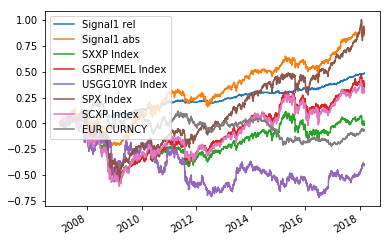

In [983]:
# Add them together and plot
account_combined=pd.concat([account_rel,account_abs,account_SXXP,account_momentum,account_yield,account_SPX,account_SCXP, account_EUR],axis=1)
account_combined.plot()

In [984]:
# Correlation matrix
account_combined.corr()

,Signal1 rel,Signal1 abs,SXXP Index,GSRPEMEL Index,USGG10YR Index,SPX Index,SCXP Index,EUR CURNCY
Signal1 rel,1.000000,0.956691,0.448513,0.703981,-0.705524,0.855723,0.713438,-0.710796
Signal1 abs,0.956691,1.000000,0.664387,0.845555,-0.579113,0.934356,0.867635,-0.701311
SXXP Index,0.448513,0.664387,1.000000,0.938746,0.056271,0.816513,0.940417,-0.428436
GSRPEMEL Index,0.703981,0.845555,0.938746,1.000000,-0.216006,0.956795,0.987617,-0.594977
USGG10YR Index,-0.705524,-0.579113,0.056271,-0.216006,1.000000,-0.404733,-0.203917,0.597327
SPX Index,0.855723,0.934356,0.816513,0.956795,-0.404733,1.000000,0.946074,-0.667395
SCXP Index,0.713438,0.867635,0.940417,0.987617,-0.203917,0.946074,1.000000,-0.602166
EUR CURNCY,-0.710796,-0.701311,-0.428436,-0.594977,0.597327,-0.667395,-0.602166,1.000000
